## Part 4: Data Modelling

## Executive Summary
1. Project Goals
    * Forecast daily bike rental demand on a city-level using multi-linear regression.
    * Predict future availability of spaces on a docking-station level using classification, requiring assumptions to be made about unbalance (surplus or deficit of bikes) on the network.
    * Determine docks which display similar patterns using network analysis and hierarchical clustering.
    * Identifying potential areas for new (or removal of) docking stations.<br>
<br>
2. Metrics Utilised
    * The main metric used will be: **Root Mean Squared Error (RMSE)** where larger error have larger weight. **R2-score** which is the amount of variance in the target above baseline, explained  by predictors, and **Median Absolute Error (MAE)** where all individual differences have equal weight are also used.<br>
<br>
3. Results
    * Multi linear regression was used initially, along with Lasso, Ridge and ElasticNet regularisation, followed by Support Vector Regressor. ElasticNet (80% Lasso/20% Ridge) performed the best out of the regularisation options for RMSE and R2, but Lasso is a clear winner for MAE.
    * Iterative approach established Gradient Boosting Regressor using GridSearch was the most optimal model choice. Within the decision tree realm this is not a surprise as generally: **Gradient Boosting > Random Forest > Bagging > Single Trees**.
    * This is due to the bias-variance trade-off, and gradient boosting's ability to optimise for variance and bias.
    * Log transformation of the target variable was not utilised due to poor performance. 
    * Network Analysis with a directed graph indicated the network can be classed as one stronly connected component, with a high average node degree of 468. Aggregative clustering indicates more journeys occuring in the north-south (or reverse) direction in central London vs. east-west (or reverse) direction in west London. The River Thames is not acting as barrier in the network. <br>
 <br>
4. Risks/limitations/assumptions
    * No record of the number of bikes available at a station when a hire is made, or how many docks are empty, when a bike is returned. The redistribution of bikes by Serco is also not accounted for.
    * The size of the dataset is too large to visualise during network analyis so alternative techniques have been used to attempt to quantify it such as aggregative clustering.

### Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, cosine, jaccard
from scipy.stats import spearmanr
import networkx as nx
import operator
import copy
from IPython.display import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (8, 5)
plt.style.use('seaborn-whitegrid')
sns.set(font_scale=1.2)

### Importing data

In [2]:
X = pd.read_csv('X_full.csv', parse_dates = True, date_parser = '%Y-%m-%d')

In [3]:
X['date'] =  pd.to_datetime(X['date'], format='%Y-%m-%d')
X.set_index('date',inplace=True)

In [4]:
X.head()

,cloud_cover,description,feels_like,humidity,max_temp,min_temp,precipitation,sun_hours,temperature,total_snow,...,wind_speed,public_holiday,business_day,school_holiday,weekend,tube_strike,total_docks,day_week,month,total_journeys
date,,,,,,,,,,,,,,,,,,,,,
2012-01-04,34,cloudy,2,81,8,3,0.0,2.9,7,0.0,...,18,0,1,0,0,0,9859,2,1,13936
2012-01-05,17,sunny,3,79,9,6,0.0,2.9,8,0.0,...,24,0,1,0,0,0,9886,3,1,14191
2012-01-06,8,sunny,3,83,6,2,0.0,2.9,6,0.0,...,10,0,1,0,0,0,9886,4,1,17713
2012-01-07,21,sunny,4,75,9,5,0.0,2.9,8,0.0,...,19,0,0,0,1,0,10144,5,1,12556
2012-01-08,30,cloudy,4,84,8,3,0.0,2.9,7,0.0,...,11,0,0,0,1,0,10144,6,1,10487


### Preparation for modelling

#### Drop Variables
The `min_temp` and `feels_like` variables will be removed from the dataset as they show high correlation with `temperature` and `wind_chill`.

In [5]:
X.drop(['min_temp', 'feels_like'], inplace = True, axis = 1)

#### Dummy Variables
* Categorical variables have no natural order (as opposed to ordinal variables where the categories have an order e.g. level of education). Dummy variables will be created for day of week, month and description. 
* With `pd.get_dummies`, using `drop_first = True` to avoid perfect collinearity, this returns n-1 for each categorical column that gets encoded, new columns are prefixed with 'weather', 'month' or 'day' and the original input column is removed.
* The dataframe is checked for any remaining variables which are of type object. The dataframe now only contains int64, uint8 and float64 types.

In [6]:
X = pd.get_dummies(data=X, columns=['description'], prefix = 'weather', drop_first = True)

In [7]:
X = pd.get_dummies(data=X, columns=['month'], prefix = 'month', drop_first = True)

In [8]:
X = pd.get_dummies(data=X, columns=['day_week'], prefix = 'day', drop_first = True)

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2148 entries, 2012-01-04 to 2017-11-20
Data columns (total 42 columns):
cloud_cover               2148 non-null int64
humidity                  2148 non-null int64
max_temp                  2148 non-null int64
precipitation             2148 non-null float64
sun_hours                 2148 non-null float64
temperature               2148 non-null int64
total_snow                2148 non-null float64
wind_chill                2148 non-null int64
wind_dir_deg              2148 non-null int64
wind_gust                 2148 non-null int64
wind_speed                2148 non-null int64
public_holiday            2148 non-null int64
business_day              2148 non-null int64
school_holiday            2148 non-null int64
weekend                   2148 non-null int64
tube_strike               2148 non-null int64
total_docks               2148 non-null int64
total_journeys            2148 non-null int64
weather_fog               2148 non-null u

#### Setting up target variable
* Remove target variable from dataframe and set to y variable.


In [10]:
y = X.pop('total_journeys')

In [11]:
print 'Returns an array of length:', len(y.values)

Returns an array of length: 2148


#### Calculate baseline prediction for dataset

In [12]:
print 'Baseline prediction for target:', np.round(y.values.mean()), 'hires per day'

Baseline prediction for target: 26272.0 hires per day


### Multi-Linear Regression
*Why use this algorithm?* There appears to be linear relationships present between the target variable and the predictor variables. It's simple to understand and explain the contributions from different variables.

For multi-linear regression there are the following critical assumptions:
* Y must have an approximately linear relationship with each independent Xi.
* Errors (residuals) ϵi and ϵj must be independent of one another for any i≠j.
* Errors (residuals) follow a normal distribution
* Errors (residuals) should have a roughly consistent pattern, regardless of the value of the Xi predictors. No discernable relationship between the X predictors and the residuals.
* Independent variables Xi and Xj must be independent of one another for any i≠j.


#### Cross Validation
* Cross validation will be carried out using both `train_test_split` and `cross_val_score`. This is to check the model's ability to generalise to new data.
* For `train_test_split`, the most basic type of hold-out validation, a value of 30% is used for the test, with the remaining 70% used for training. The train and test split is based on `random_state` which is the seed using by the random number generator.
* For cross_val_score, in each of the k folds a different model is built with different coefficients depending on the training set of data which is used. This is then applied to the  "validation" set and the output metric applied. A k of 10 will be used.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.3, random_state = 8)
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(1503, 41) (1503,)
(645, 41) (645,)


#### Standardisation 
Scale predictor variables to handle any disparities present in the units and precent steps on different axis from varying widely. Standardisation allows direct comparison of the magnitude of impact between different predictors as beta coefficients have similar magnitudes. The fit and transform is carried out on the training set, whereas only the transform is applied to the test set.

In [14]:
ss = StandardScaler()
Xs = pd.DataFrame(ss.fit_transform(X_train),columns=X_train.columns)

In [15]:
Xt = pd.DataFrame(ss.transform(X_test),columns=X_test.columns)

In [16]:
Xtot = pd.DataFrame(ss.fit_transform(X), columns=X.columns)

#### Fit and Score Model - Train/Test Split

Fit, predict and score an Sklearn LinearRegression model. A function is defined to allow rapid plotting of the true y and predicted y values vs a perfect model and the baseline.

In [17]:
lm = LinearRegression()
model1 = lm.fit(Xs, y_train)
R2 = model1.score(Xt, y_test)
print "R2 Score:", R2
yhat = model1.predict(Xt)
RMSE = np.sqrt(mean_squared_error(yhat, y_test))
print 'RMSE:', RMSE
MAE = median_absolute_error(y_test, yhat)
print 'MAE:', MAE

R2 Score: 0.74089176421
RMSE: 4528.44448744
MAE: 2472.26185473


In [18]:
def plot_y_yhat(y_test, yhat):
     
    plt.figure(figsize=(10,7))
    plt.scatter(y_test, yhat, color='darkgoldenrod', s=30, label='yhat - true y')

    max_val = np.max(y_test)
    min_val = np.min(y_test)

    plt.plot([min_val, max_val], [min_val, max_val], color='darkgreen',
            linewidth=4.0, alpha=0.7, label='perfect model')
    
    plt.axhline(y=y_train.mean(), linewidth = 4, label = 'baseline prediction')

    plt.xlabel('True y', fontsize=16)
    plt.ylabel('y predictions', fontsize=16)

    plt.legend(loc='upper left')

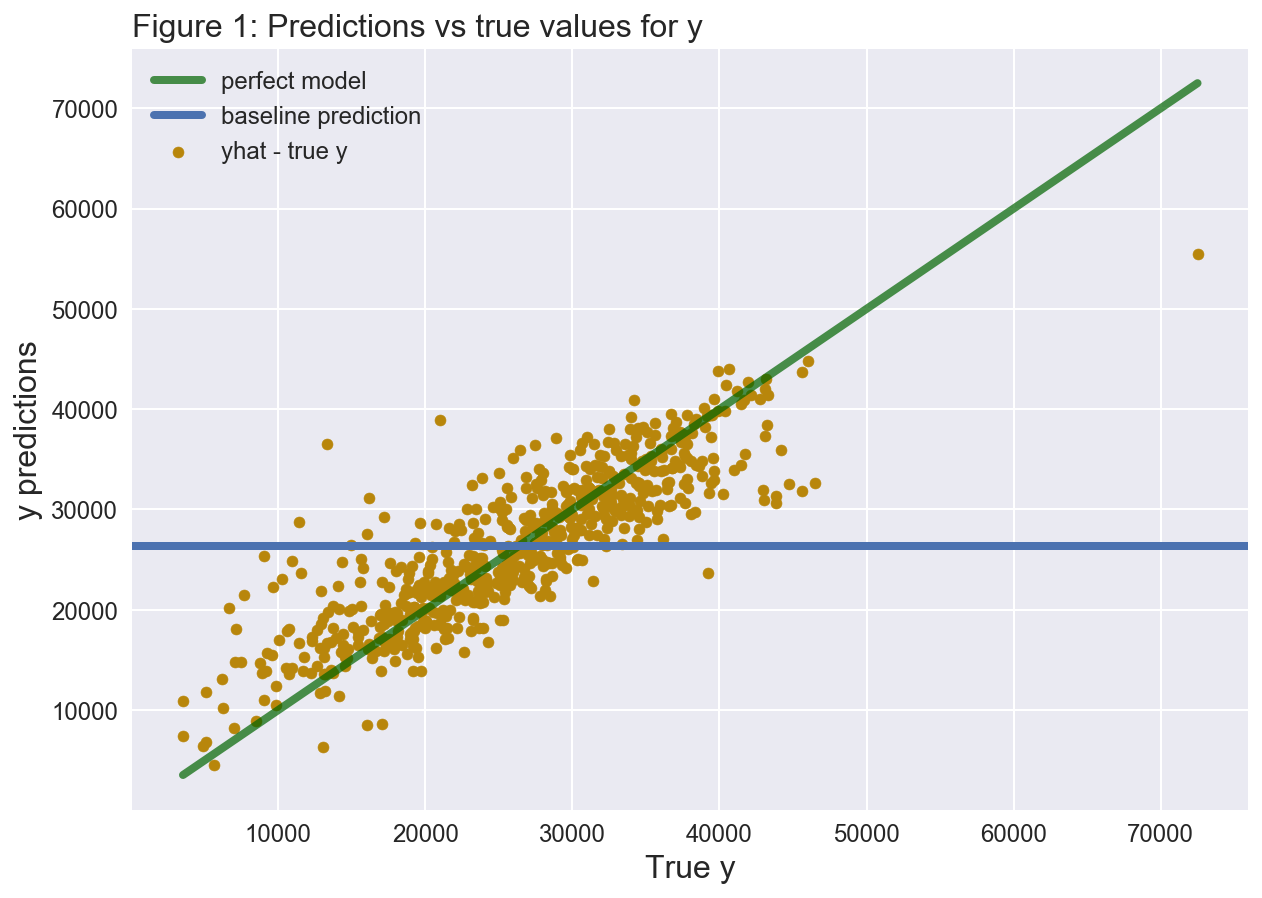

In [19]:
plot_y_yhat(y_test, yhat)
plt.title('Figure 1: Predictions vs true values for y', loc = 'left', fontsize = 16)
plt.show()
           

In [20]:
model1_coeff = pd.DataFrame({'variable': Xs.columns, 'coeff' : model1.coef_, 'abs_coeff': np.abs(model1.coef_)})

In [21]:
# These seems a litte surprising at the top three positive coeffecients as day_5 and day_6 are Saturday and Sunday, 
# and should entirely opposite to business_day
model1_coeff.sort_values('coeff', ascending = False).head(10)

,abs_coeff,coeff,variable
39,3437.564669,3437.564669,day_5
40,3182.624095,3182.624095,day_6
12,3063.659922,3063.659922,business_day
2,2778.095130,2778.095130,max_temp
7,2509.825293,2509.825293,wind_chill
16,1696.183573,1696.183573,total_docks
29,1307.374942,1307.374942,month_7
30,1296.185462,1296.185462,month_8
4,1201.613470,1201.613470,sun_hours
32,1127.081959,1127.081959,month_10


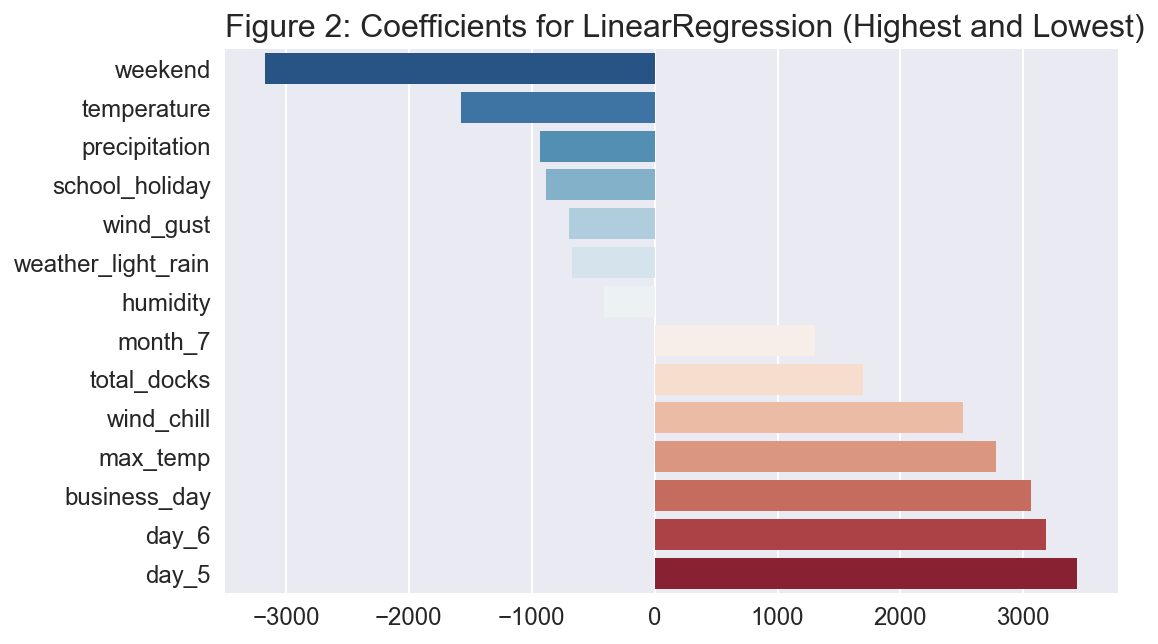

In [22]:
coef = pd.Series(model1.coef_, index = Xs.columns)
sort_coef = pd.concat([coef.sort_values().head(7),
                      coef.sort_values().tail(7)])

sns.barplot(y = sort_coef.index, x = sort_coef.values, palette = "RdBu_r")
plt.title("Figure 2: Coefficients for LinearRegression (Highest and Lowest)", loc = 'left', fontsize = 16)
plt.show()

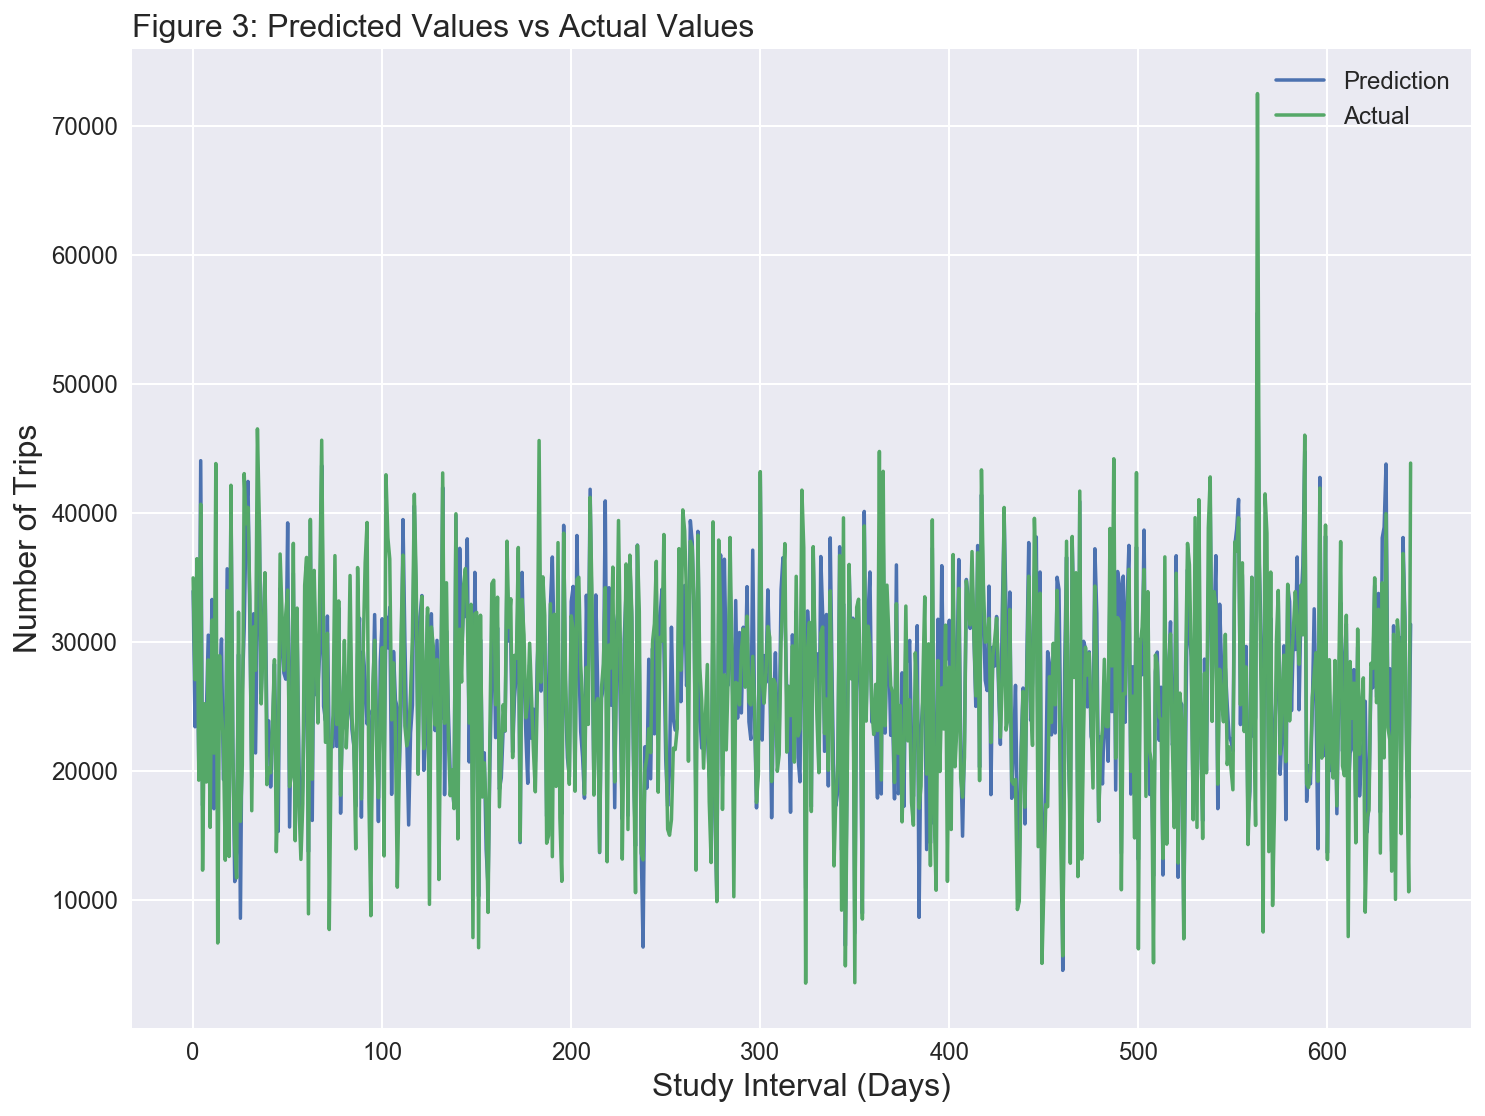

In [23]:
fs = 16
plt.figure(figsize=(12,9))
plt.plot(yhat)
plt.plot(y_test) # Selected 200 days to make visualise comparison easier
plt.legend(['Prediction', 'Actual'])
plt.ylabel("Number of Trips", fontsize = fs)
plt.xlabel("Study Interval (Days)", fontsize = fs)
plt.title("Figure 3: Predicted Values vs Actual Values", fontsize = fs, loc = 'left')
plt.show()

Plot the residuals to see if there are any trends visible - they appear to be randomly distibuted.

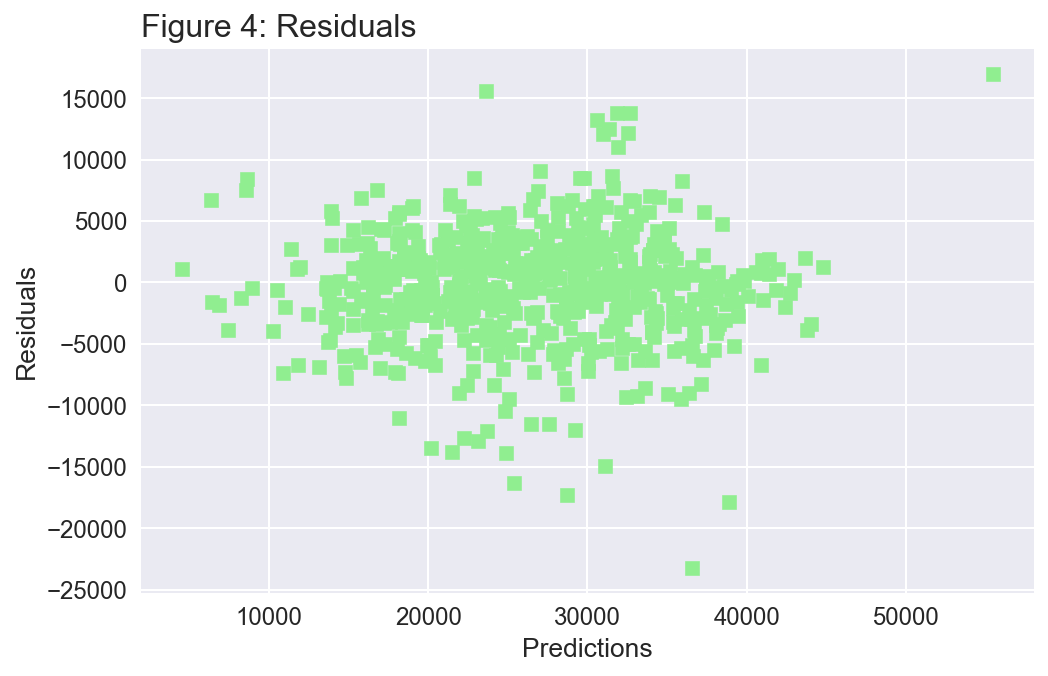

In [24]:
plt.scatter(yhat, y_test - yhat, c = "lightgreen", marker = "s")
plt.xlabel("Predictions")
plt.ylabel("Residuals")
plt.title("Figure 4: Residuals", fontsize = fs, loc = 'left')
plt.show()

#### Fit and score model - Cross validation score
There is a risk of overfitting using the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model. To solve this problem, another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set. In cross validation, a test set should still be held out for final evaluation, but no separate validation set is needed.

Use the same `lm` model which was instantiated in the section above to carry out cross validation with a fold of 10. Three scorers are set up using RMSE, MAE and R2-score. RMSE is more desirable when large errors need to be avoided, MAE gives the absolute error so does not penalise larger errors more.

In [25]:
def RMSE_CV(model):
    RMSE = np.sqrt(-cross_val_score(model, Xs, y_train, scoring="neg_mean_squared_error", cv = 10))
    return np.round(np.mean(RMSE),2)
print RMSE_CV(lm)

4435.37


In [26]:
def MAE_CV(model):
    scores = cross_val_score(model, Xs, y_train, cv=10, n_jobs=1, scoring = 'neg_median_absolute_error')
    return np.round((np.median(scores) * -1),0)
print MAE_CV(lm)

2720.0


In [27]:
def R2_CV(model):
    R2 = cross_val_score(model, Xs, y_train, scoring="r2", cv = 10)
    return np.round(np.mean(R2),4)
print R2_CV(lm)

0.7244


In [28]:
# Set up lists to keep track of scores. RMSE will be used as the main metric 
# for comparison throughout.
method = []
RMSE_metric = []
method.append('LinearRegressionCV')
RMSE_metric.append(RMSE_CV(lm))

In [29]:
# If not specified, uses signature scorer associated with model, r2-score in this case.
scores = cross_val_score(lm, Xs, y_train, cv=10)
predictions = cross_val_predict(lm, Xt, y_test, cv=5)
print np.mean(scores)

0.724441020445


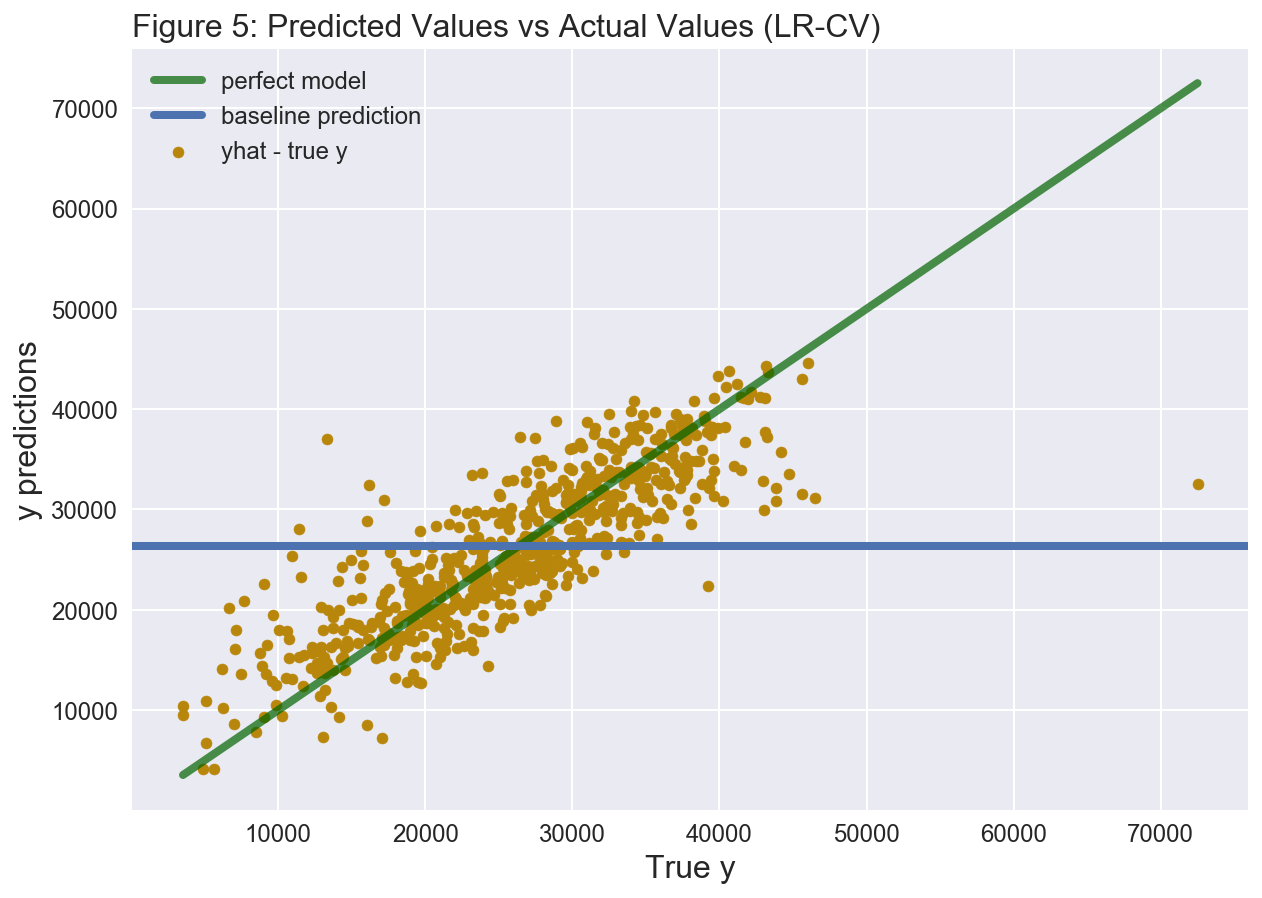

In [30]:
plot_y_yhat(y_test, predictions)
plt.title("Figure 5: Predicted Values vs Actual Values (LR-CV)", fontsize = fs, loc = 'left')
plt.show()

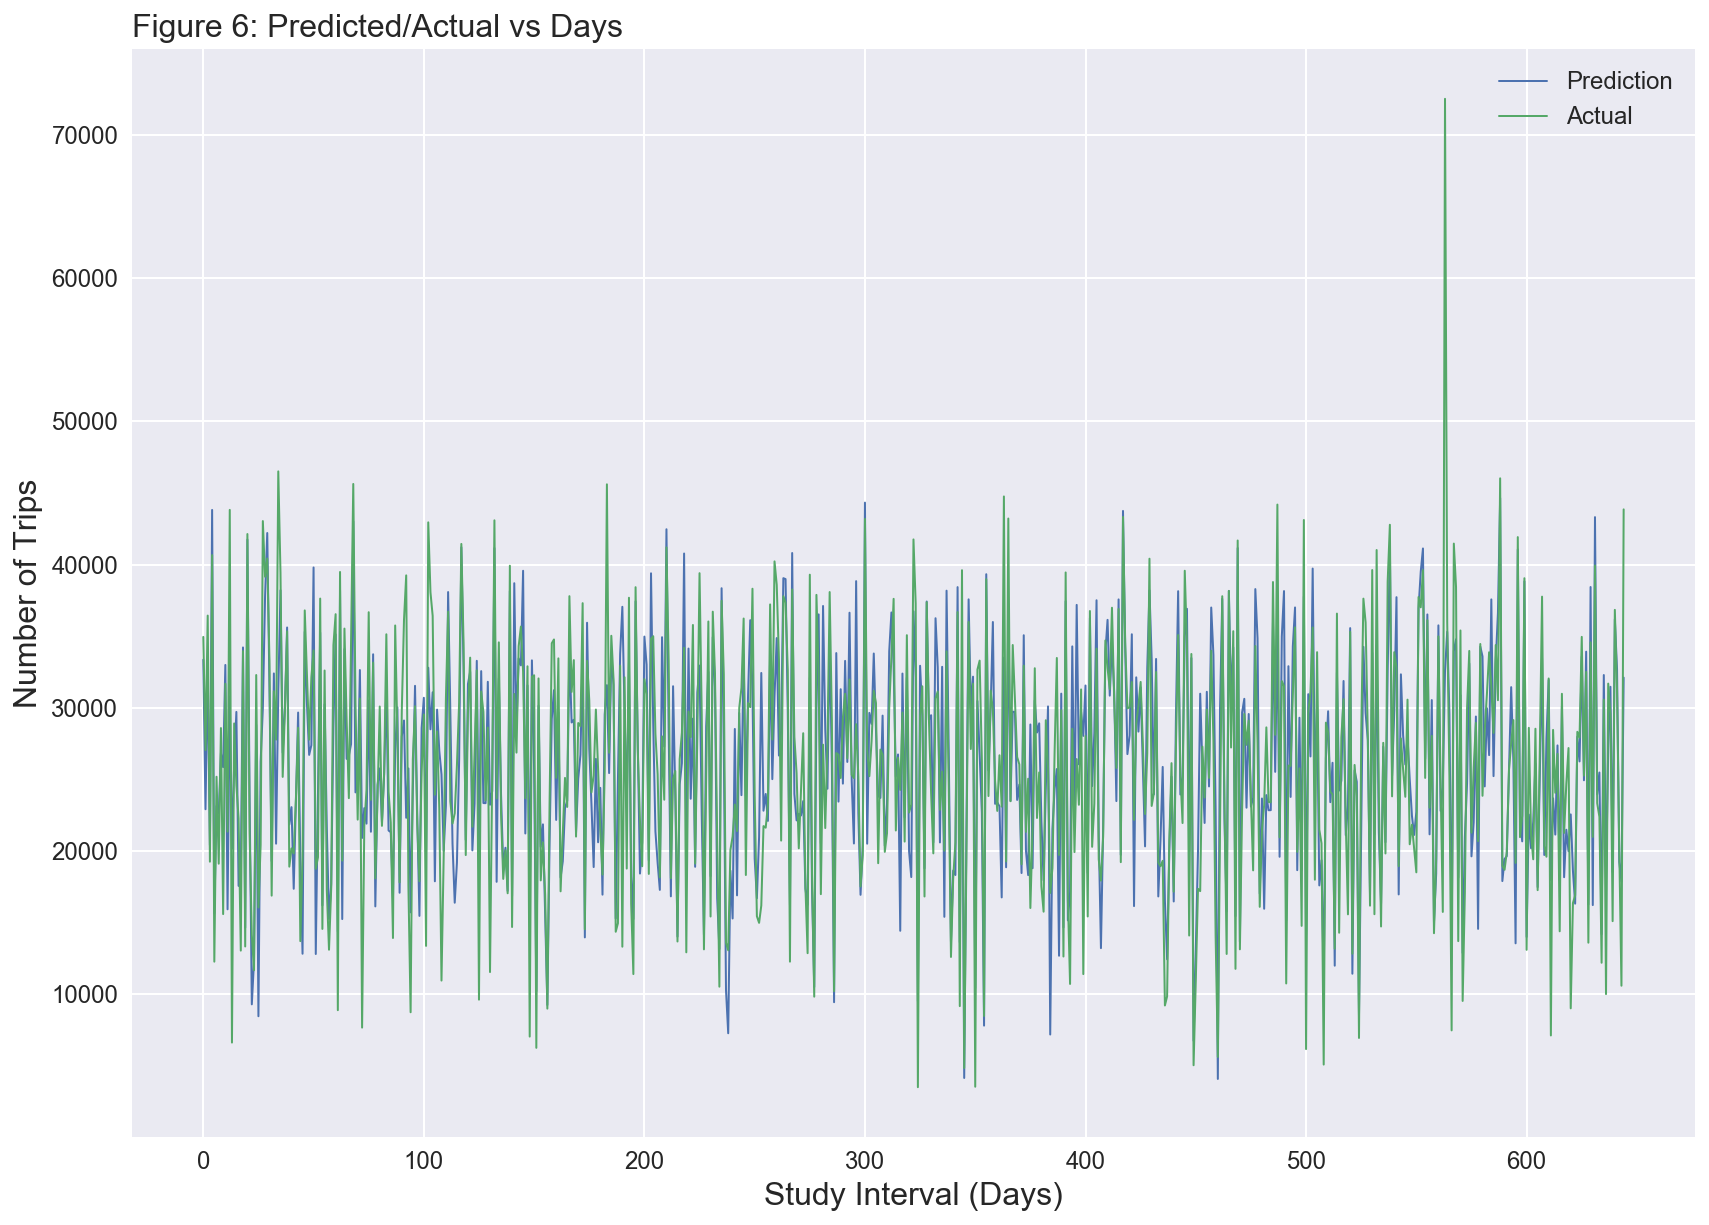

In [31]:
fs = 16
plt.figure(figsize=(14,10))
plt.plot(predictions, linewidth = 1)
plt.plot(np.array(y_test), linewidth = 1)
plt.legend(['Prediction', 'Actual'])
plt.ylabel("Number of Trips", fontsize = fs)
plt.xlabel("Study Interval (Days)", fontsize = fs)
plt.title("Figure 6: Predicted/Actual vs Days", fontsize = fs, loc = 'left')
plt.show()

#### Log Transform Dependent Variable

Errors, as estimated by the residuals, are assumed to be normally distributed. When they are positively skewed taking logs may help. The target variable has a slight postive skew, with a much longer right hand tail so performing a log tranformation will be tested.


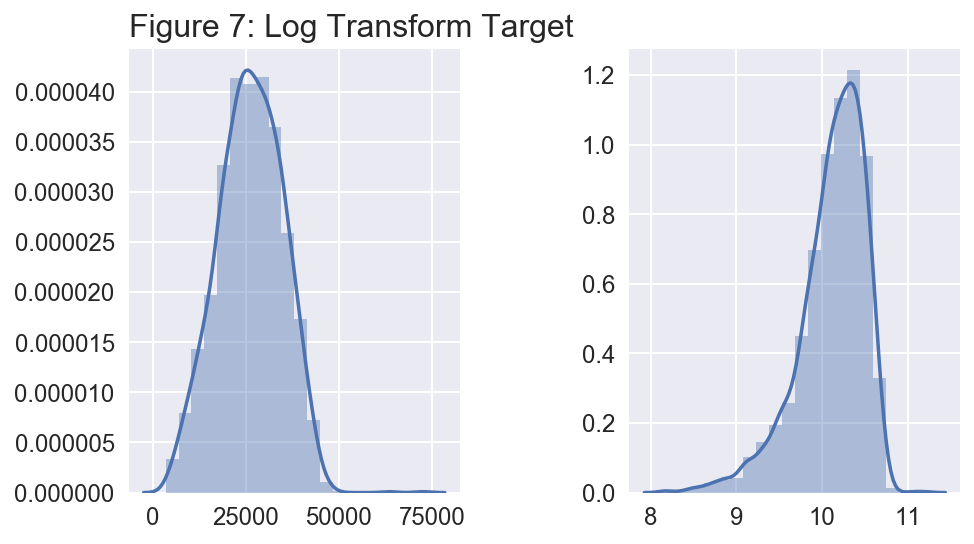

In [32]:
target = np.array(y)
plt.figure(figsize = (7, 4))
plt.subplot(1,2,1)
sns.distplot(target, bins = 20)
plt.title('Figure 7: Log Transform Target', loc = 'left', fontsize = fs)
plt.subplot(1, 2, 2)
sns.distplot(np.log1p(target), bins = 20)
plt.tight_layout()
plt.show()

In [33]:
y_train_l = np.log1p(y_train)
y_test_l = np.log1p(y_test)
y_l = np.log1p(y)
model2 = lm.fit(Xs, y_train_l)
yhat = model2.predict(Xt)

R2 = r2_score(np.exp(yhat), np.exp(y_test_l))
print 'R2:', R2
print 'RMSE:', np.sqrt(mean_squared_error(np.exp(yhat), np.exp(y_test_l)))
print 'MAE:', median_absolute_error(np.exp(yhat), np.exp(y_test_l))


R2: 0.678461359171
RMSE: 4798.16928044
MAE: 3119.4447795


#### Regularisation
The goal of regularisation is to structurally prevent overfitting by imposing a penalty on the coefficients of the model. The larger the lambda, the lower the coefficients required to keep loss low. Lasso, Ridge and ElasticNet will be tested with GridSearch. *Why use GridSearching?* Gridsearching can be used to find the optimal hyperparameters for the model. It gets its name from the fact is searches over a “grid” of parameters, using cross validation internally, to find the optimal set of hyperparameters for the model.
* Ridge regularisation ouputs the most optimal value of alpha as 10. The RMSE score is on a par with cross-validated linear regression. `wind_chill`, `max_temp`, `total_docks` are the highest ranking features. 
* Lasso regularisation outputs the most optimal value of alpha as 2 with an RMSE comparable to Ridge. `business_day`, `day_5`, `max_temp` are the highest coefficients for this model (different to the other methods of regularisation), with `weekend`, `temperature` and `precipitation` the largest negative coefficients.
* ElasticNet has a slightly lower R2 at 0.7245 with an alpha of 0.1 and mixture of 80% L1/20% L2, `total_docks`, `max_temp` and `wind_chill` are the highest postive coefficents. 
* `max_temp` appears repeatedly within the top three model coefficients.


In [41]:
# Use GridSearch to test Ridge (L2) regularisation
ridge_m = Ridge()
ridge_params = {'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100]}
grid_ridge = GridSearchCV(ridge_m, ridge_params, cv=10, scoring = 'neg_mean_squared_error')

# Best parameters when fit with the whole training set:
grid_ridge.fit(Xs, y_train)
print grid_ridge.best_params_

RMSE = np.sqrt(-(grid_ridge.best_score_))
print 'Best score:', RMSE

method.append('LR_GSCV_Ridge')
RMSE_metric.append(RMSE)

{'alpha': 10, 'max_iter': 3000}
Best score: 4443.28623441


RMSE on test data: 4509.11120507


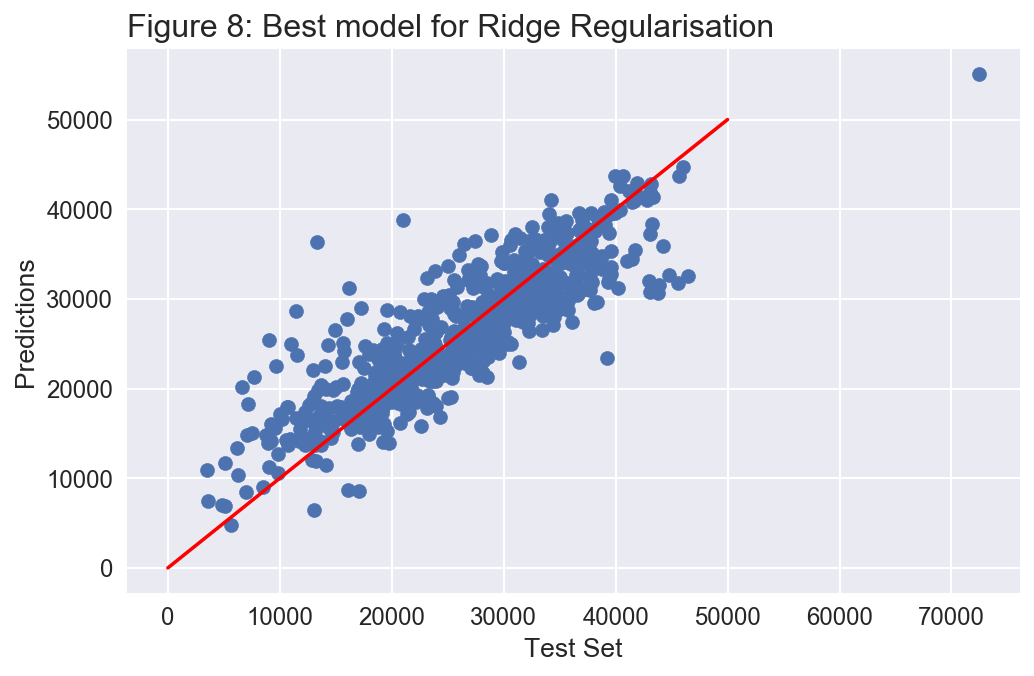

In [42]:
# Make predictions using the test set
preds = grid_ridge.predict(Xt)
print 'RMSE on test data:', np.sqrt(mean_squared_error(y_test, preds))

# Plot the predictions vs. the test set
plt.scatter(y_test, preds)
point_1 = [0, 50000]
plt.plot(point_1,point_1, color = 'r')
plt.title('Figure 8: Best model for Ridge Regularisation', loc = 'left', fontsize = fs)
plt.xlabel("Test Set")
plt.ylabel("Predictions")
plt.show()

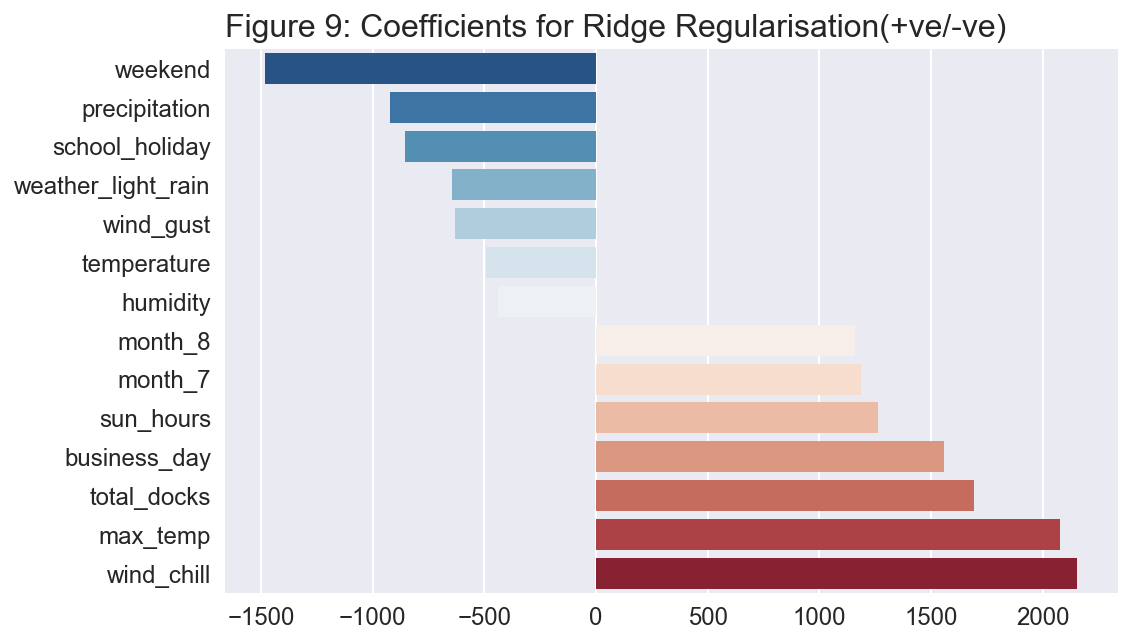

In [43]:
coef = pd.Series(grid_ridge.best_estimator_.coef_, index = Xtot.columns)
sort_coef = pd.concat([coef.sort_values().head(7),
                      coef.sort_values().tail(7)])

sns.barplot(y = sort_coef.index, x = sort_coef.values, palette = "RdBu_r")
plt.title("Figure 9: Coefficients for Ridge Regularisation(+ve/-ve)", loc = 'left', fontsize = fs)
plt.show()

In [45]:
# Use GridSearch to test Lasso (L1) regularisation
alpha  = [1, 2, 5, 10, 15, 20, 25]
lasso_m = Lasso()
lasso_params = {'max_iter':[3000],'alpha':alpha}
grid_lasso = GridSearchCV(lasso_m, lasso_params, cv=10, scoring = 'neg_mean_squared_error')

# Best parameters when fit with the whole training set:
grid_lasso.fit(Xs, y_train)
print grid_lasso.best_params_

RMSE = np.sqrt(-(grid_lasso.best_score_))
print 'Best score:', RMSE

method.append('LR_GSCV_Lasso')
RMSE_metric.append(RMSE)

{'alpha': 2, 'max_iter': 3000}
Best score: 4442.68998662


RMSE on test data: 4521.08590976


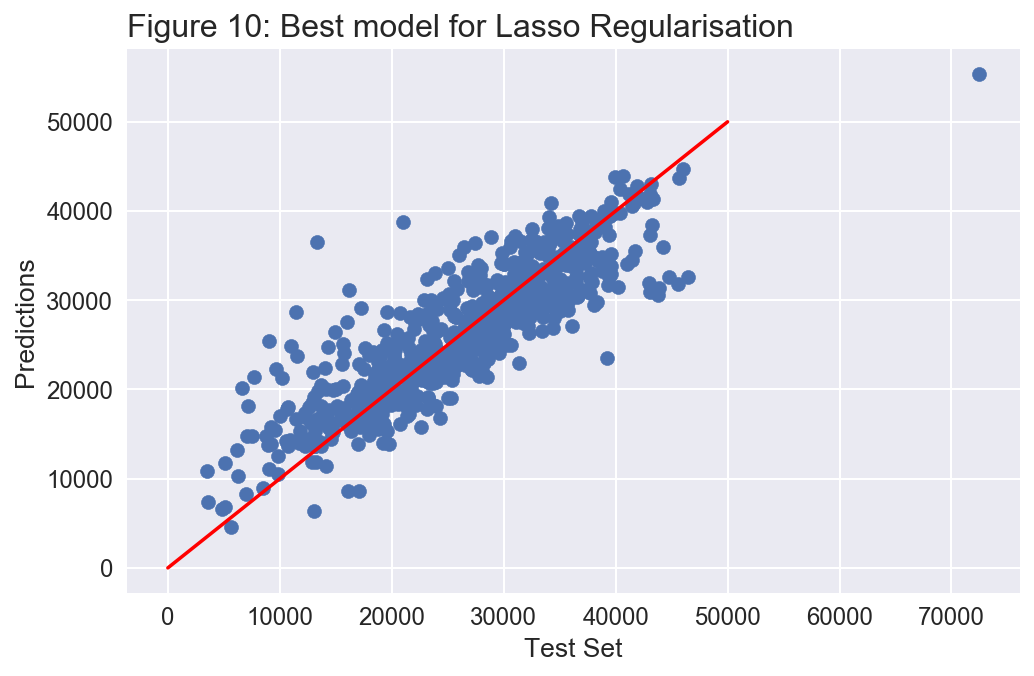

In [46]:
# Make predictions using the test set
preds = grid_lasso.predict(Xt)
print 'RMSE on test data:', np.sqrt(mean_squared_error(y_test, preds))

# Plot the predictions vs. the test set
plt.scatter(y_test, preds)
point_1 = [0, 50000]
plt.plot(point_1,point_1, color = 'r')
plt.title("Figure 10: Best model for Lasso Regularisation", loc = 'left', fontsize = fs)
plt.xlabel("Test Set")
plt.ylabel("Predictions")
plt.show()

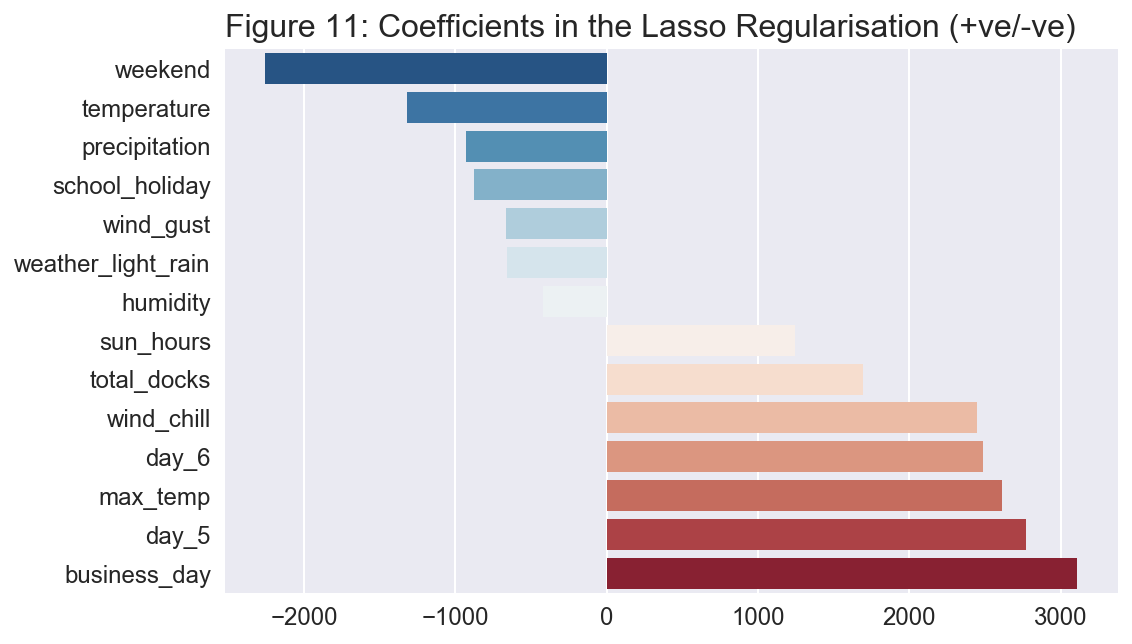

In [47]:
coef = pd.Series(grid_lasso.best_estimator_.coef_, index = Xtot.columns)
sort_coef = pd.concat([coef.sort_values().head(7),
                      coef.sort_values().tail(7)])

sns.barplot(y = sort_coef.index, x = sort_coef.values, palette = "RdBu_r")
plt.title("Figure 11: Coefficients in the Lasso Regularisation (+ve/-ve)", loc = 'left', fontsize = fs)
plt.show()

In [48]:
# Use GridSearch to test Elastic Net (combination of L2/L1) regularisation
elastic_m = ElasticNet()
elastic_params = {'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200], 'l1_ratio': np.arange(0.1, 0.9, 0.1) }
grid_elastic = GridSearchCV(elastic_m, elastic_params, cv=10, scoring = 'neg_mean_squared_error')

# Best parameters when fit with the whole training set:
grid_elastic.fit(Xs, y_train)
print grid_elastic.best_params_

RMSE = np.sqrt(-(grid_elastic.best_score_))
print 'Best score:', RMSE

method.append('LR_GSCV_Elastic')
RMSE_metric.append(RMSE)

{'alpha': 0.1, 'max_iter': 3000, 'l1_ratio': 0.80000000000000004}
Best score: 4444.42089252


RMSE on test data: 4503.25633617


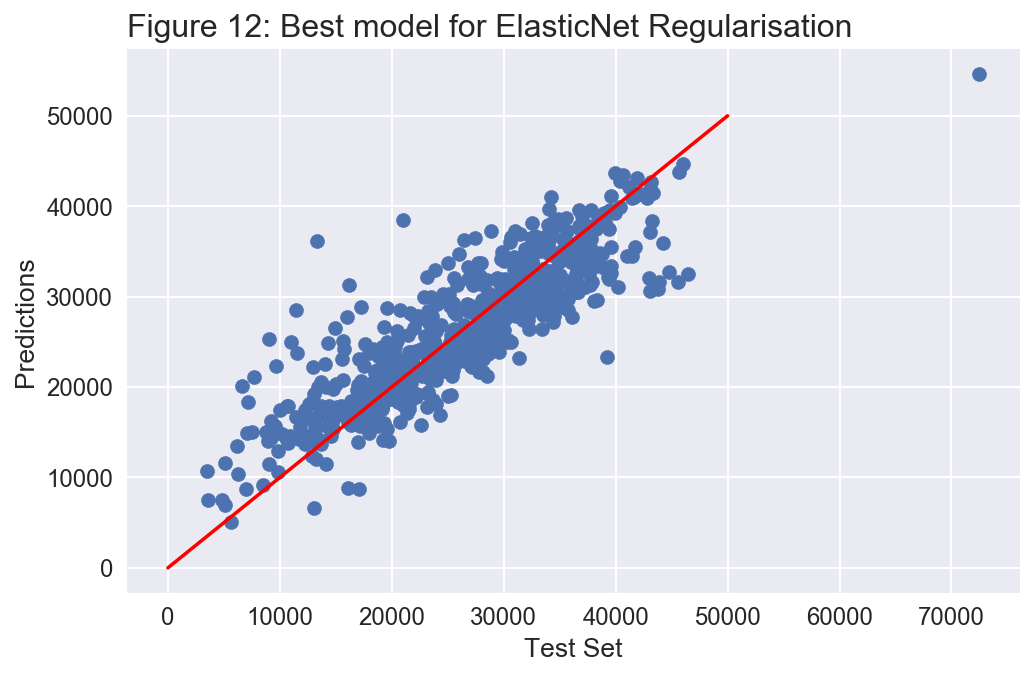

In [49]:
# Make predictions using the test set:
preds = grid_elastic.predict(Xt)
print 'RMSE on test data:', np.sqrt(mean_squared_error(y_test, preds))

# Plot the predictions vs. the test set
plt.scatter(y_test, preds)
point_1 = [0, 50000]
plt.plot(point_1,point_1, color = 'r')
plt.title('Figure 12: Best model for ElasticNet Regularisation', loc = 'left', fontsize = fs)
plt.xlabel("Test Set")
plt.ylabel("Predictions")
plt.show()

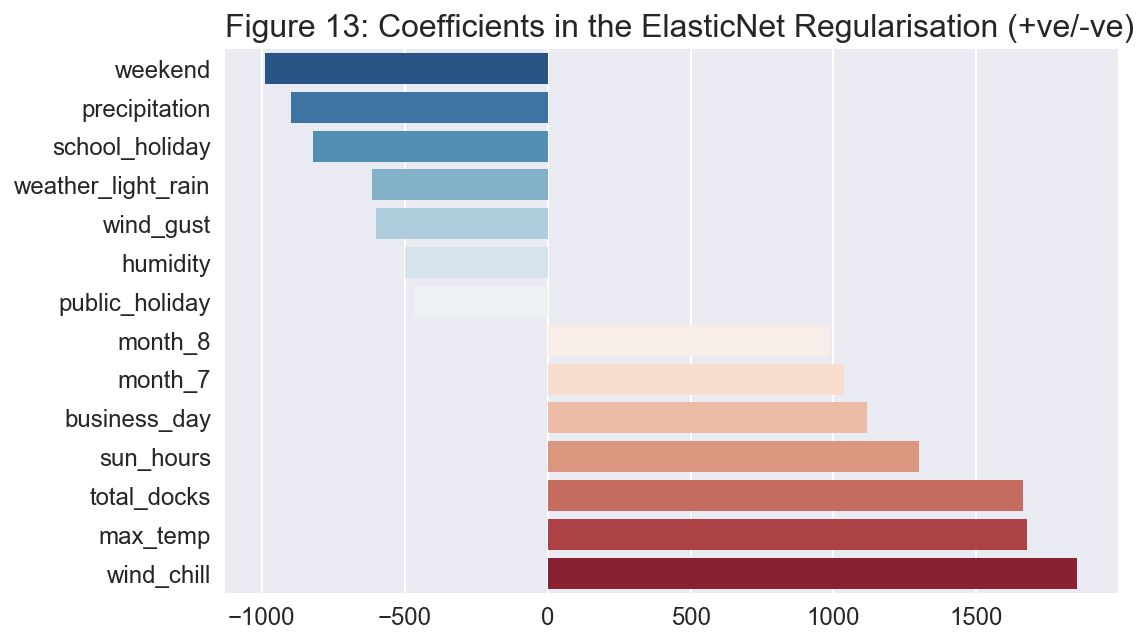

In [50]:
coef = pd.Series(grid_elastic.best_estimator_.coef_, index = Xtot.columns)
sort_coef = pd.concat([coef.sort_values().head(7),
                      coef.sort_values().tail(7)])

sns.barplot(y = sort_coef.index, x = sort_coef.values, palette = "RdBu_r")
plt.title("Figure 13: Coefficients in the ElasticNet Regularisation (+ve/-ve)", loc = 'left', fontsize = fs)
plt.show()

### Support Vector Regressor
The 'best' model has a linear kernel and C equal to 100, it performs worse than all of the Linear Regression models.

In [52]:
model_rbf = SVR()

params_rbf = [{'kernel': ['rbf'], 'gamma': np.logspace(-5, 2, 3),
                     'C': np.logspace(-3, 3, 6)},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

grid_svm = GridSearchCV(model_rbf, param_grid=params_rbf, cv=5, verbose=1, n_jobs = -1, scoring = 'neg_mean_squared_error')

# Best parameters when fit with the whole training set:
grid_svm.fit(Xs, y_train)
print grid_svm.best_params_

RMSE = np.sqrt(-(grid_svm.best_score_))
print 'Best score:', RMSE

method.append('SVM_GS')
RMSE_metric.append(RMSE)

# Making predictions using the test set:
preds = grid_svm.predict(Xt)
print 'RMSE on test set:', np.sqrt(mean_squared_error(y_test, preds))

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:   13.1s finished


{'kernel': 'linear', 'C': 100}
Best score: 4485.82127495
RMSE: 4545.26092386


### Ensemble Methods

Ensembling refers to creating mutiple models and then combining them to produce improved results. 

#### Random Forest Regressor

*Why use this algorithm?* Straight out of the box decision trees tend to grow deep and as a result learn highly irregular patterns leading to an overfit of the training set (high variance). **Bagging** can help to mitigate this problem by exposing different trees to different sub-samples of the whole training set. 

Random Forest uses a modified decision tree learning algorithm that selects, at each candidate split, a random subset of the features. Often one or a few features are very strong predictors for the target (e.g. temperatures and variables related to it in our case) and are always selected in bagging base trees. Selecting a random subset of features at each split avoids this correlation. 

The gridsearched best estimated model has an RMSE of 4113, fitted with `n_estimators` of 400, `max_features` of 40 and `min_samples_leaf` of 2. `wind_chill`, `max_temp` and `business_day` are the highest ranked features.

In [55]:
model5 = RandomForestRegressor()

gs_params_RF = { 'n_estimators' : [50, 70, 90, 150, 200, 300, 400], 'min_samples_leaf' : [2,3,4], 'max_features': [10, 15, 20, 25, 30, 35, 40]}

grid_rf = GridSearchCV(model5, gs_params_RF, cv=5, verbose=1, n_jobs = -1, scoring = 'neg_mean_squared_error')

grid_rf.fit(Xs, y_train)
print grid_rf.best_params_

RMSE = np.sqrt(-(grid_rf.best_score_))
print 'Best score:', RMSE

method.append('RFR_GS')
RMSE_metric.append(RMSE)

best_gs_rf = grid_rf.best_estimator_
preds = best_gs_rf.predict(Xt)
print 'RMSE on test set:', np.sqrt(mean_squared_error(y_test, preds))

{'max_features': 40, 'n_estimators': 400, 'min_samples_leaf': 2}


In [56]:
# Top 5 features in terms of importance
zipped = zip(Xt.columns, best_gs_rf.feature_importances_)
zipped.sort(key = lambda t: t[1], reverse = True)

for i, j in enumerate(zipped[:10]):
    print i+1, j

1 ('wind_chill', 0.39783587763550771)
2 ('max_temp', 0.15314022919697956)
3 ('business_day', 0.099610307207383009)
4 ('total_docks', 0.072927417255363031)
5 ('humidity', 0.056204092201820821)
6 ('sun_hours', 0.032859110527282312)
7 ('temperature', 0.029369817652224593)
8 ('cloud_cover', 0.025754152539156184)
9 ('wind_dir_deg', 0.023682852086417606)
10 ('precipitation', 0.022599486465586537)


#### Gradient Boosting Regressor
*Why use this algorithm?* Gradient boosting is able to provide smooth detailed predictions by combining many trees of very limited depth. Each subsequent tree is fitted to the residuals of the data. Hence each subsequent iteration is slowly improving the overall strong learner by improving its performance in poorly-performing regions of the feature space. Least Absolute Deviation (LAD) will be tested as well as Least Squares for the loss function.<br>
<br>
The MAE, RMSE and R2 are all improved using the Least Squares loss function rather than Least Absolute Deviation. At 3975, Gradient Boosting with least squares is performing better than the grid searched Random Forest Regressor.

In [57]:
model3 = GradientBoostingRegressor(loss = 'lad')

print "R2:", R2_CV(model3)
print "MAE:", MAE_CV(model3)
RMSE = RMSE_CV(model3)
print "RMSE:", RMSE

method.append('GBR_LAD')
RMSE_metric.append(RMSE)

R2: 0.7707
MAE: 2125.0
RMSE: 4046.05


In [58]:
model4 = GradientBoostingRegressor() # Uses least squares loss function by default.

RMSE = RMSE_CV(model4)
print "RMSE:", RMSE
print "MAE:", MAE_CV(model4)
print "R2:", R2_CV(model4)

method.append('GBR_LS')
RMSE_metric.append(RMSE)

RMSE: 3974.95
MAE: 2096.0
R2: 0.7778


#### GradientBoost Regressor GridSearch
The following parameters have been tested:
* n_estimators: number of boosting stages to perform, technique is fairly robust to overfitting so large numbers usually give better performance. 
* max_features: number of features to consider when looking for the best split.
* learning_rate: shrinks the contribution of each tree by the learning rate.
* max_depth: maximum depth of the individual regression estimators, limits number of nodes

The best RMSE from the training data is 3778, with the optimised model yielding an RMSE on the test set of 3728 and 1997 median absolute error. This model is fit with `max_features` of 10, `loss` of least squares, `learning_rate` of 0.1, `n_estimators` at 400 and `max_depth` of 3. `total_docks`, `wind_dir_deg` and `humidity` are the highest ranked features. `wind_dir_deg` is a surprise has not been picked up as a key variable by any of the other models. The top 10 features are notable in that they include only one non-weather variable, `total_docks`.

In [59]:
# Using model4 which was instantiated in the previous section.
gs_params_GB = {'loss':['ls', 'lad'], 'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4] , 'max_depth': [1, 2, 3, 4], 'max_features': [10,15,20,25,30,35,40],'n_estimators':[50, 70, 90, 150, 200, 300, 400]}

grid_gb = GridSearchCV(model4, gs_params_GB, cv=5, verbose=1, n_jobs = -1, scoring = 'neg_mean_squared_error')

grid_gb.fit(Xs, y_train)
print 'Best parameters:', grid_gb.best_params_

RMSE = np.sqrt(-(grid_gb.best_score_))
print 'Best score:', RMSE

method.append('GBR_GS')
RMSE_metric.append(RMSE)

best_gs_gb = grid_gb.best_estimator_
preds = best_gs_gb.predict(Xt)
print 'RMSE on test set:', np.sqrt(mean_squared_error(y_test, preds))
print 'MAE on test set:', median_absolute_error(y_test, preds)

Fitting 5 folds for each of 1960 candidates, totalling 9800 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 534 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1134 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1584 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2252 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 3062 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 3812 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 4662 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 5612 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 6941 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 8091 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 9341 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 9800 out of 9800 | elapsed: 23.9min finished


Best parameters: {'max_features': 10, 'loss': 'ls', 'learning_rate': 0.1, 'n_estimators': 400, 'max_depth': 3}
Best score: 3778.72234868
RMSE on test set: 3728.02001328
MAE on test set: 1997.05168669


In [61]:
# Top 5 features in terms of importance
zipped = zip(Xt.columns, best_gs_gb.feature_importances_)
zipped.sort(key = lambda t: t[1], reverse = True)

for i, j in enumerate(zipped[:10]):
    print i+1, j

1 ('total_docks', 0.14484804864325929)
2 ('wind_dir_deg', 0.084405832841913608)
3 ('humidity', 0.080205480800079734)
4 ('wind_gust', 0.067972016352301615)
5 ('wind_speed', 0.059173169518268488)
6 ('max_temp', 0.057692496396686811)
7 ('cloud_cover', 0.056155772924539028)
8 ('wind_chill', 0.054598456193172898)
9 ('precipitation', 0.054409811602480804)
10 ('temperature', 0.054228821764768058)


#### Comparison of Random Forest and Gradient Boosting
Random Forest uses fully grown decision trees (low bias, high variance). The trees are made uncorrelated to maximize the decrease in variance. It cannot reduce bias, so ideally large unpruned trees are needed so the bias is already low initially. It grows trees in parallel. 

Boosting algorithms can play a crucial role in dealing with bias variance trade-off.  Unlike bagging algorithms, which only controls for high variance. Gradient Boost is based on shallow trees - weak base learners with high bias, low variance. Each subsequent tree is fitted to the residuals of the data. Hence each subsequent iteration is slowly improving the overall strong learner by improving its performance in poorly-performing regions of the feature space. This reduces the bias, but also the variance by aggregation of output from many sequential models. No weighting for gradient boosting, sum together at end.

The models are successively built using the training set, varying the n_estimators and max_features and the resulting errors visualised. The hyperparameters tested were:

* *n_estimators:* RandomForest outperforms GradientBoosting when number of estimators is high - this is to be expected as it uses fully grown decision trees, so would perform reasonably at low values of n_estimatprs. As this value increases the RMSE begins to converge, until c.200 estimators where both are relatively stable, and GB is slightly outperforming RF.<br>
<br>
* *max_features:* Note: n_estimators set to 200 so GB performs consistently better than RF. RF is improving consistently as the max_features increases, whereas GB appears to be optimal at 10-15 features. MAE is fairly unstable over this hyperparameter interval, particularly for GB and does not stabilise for either algorithm. 

In [71]:
values = sorted(list(set(np.logspace(0, 3, num=20, endpoint=True, base=10.0).astype(int))))

In [72]:
score_list = []
for n in values:
    models = [('GradientBoost',GradientBoostingRegressor(loss = 'ls', random_state=1, n_estimators=n)),
          ('RandomForest',RandomForestRegressor(random_state=1, n_estimators=n))
             ]
    for model in models:
        score = RMSE_CV(model[1])
        MAE = MAE_CV(model[1])
        score_list.append([model[0], n, score, MAE])

In [73]:
scores = pd.DataFrame(score_list,columns=['model','estimators','rmse', 'mae'])
scores.head()

,model,estimators,rmse,mae
0,GradientBoost,1,8011.86,5983.0
1,RandomForest,1,5855.62,2909.0
2,GradientBoost,2,7559.73,5580.0
3,RandomForest,2,4972.48,2732.0
4,GradientBoost,4,6828.47,4897.0


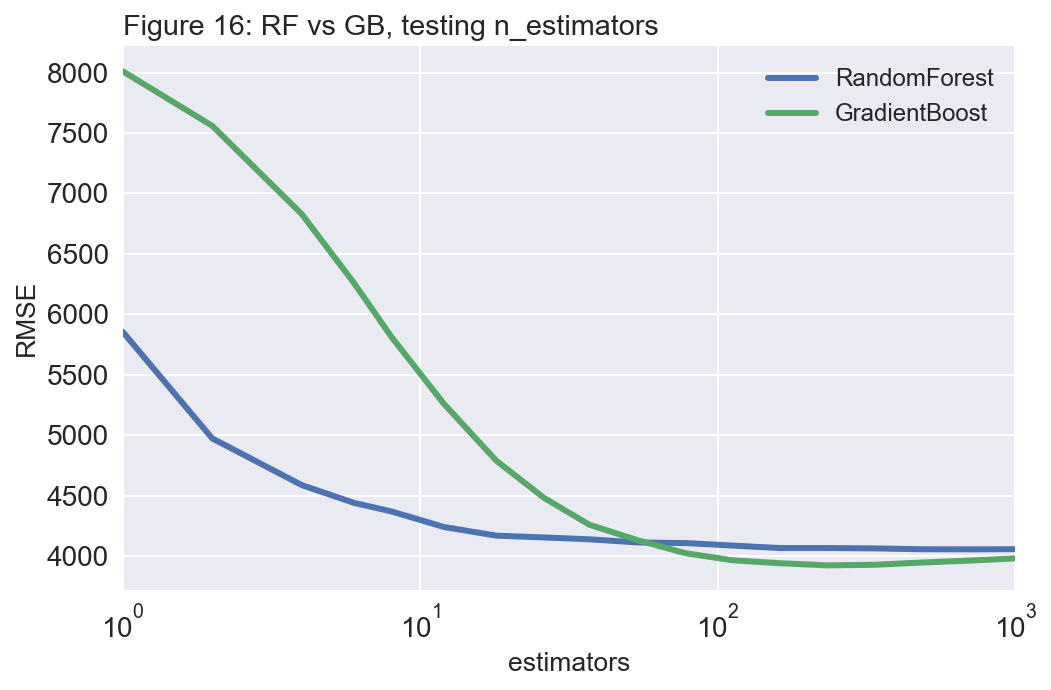

In [74]:
groups = scores.groupby('model')

fig, ax = plt.subplots()
for group in groups.groups.keys():
    groups.get_group(group).plot(x='estimators', y='rmse', ax=ax,
                                 label=group, lw=3, fontsize=14, logx=True)

plt.title('Figure 14: RF vs GB, testing n_estimators', loc = 'left')
plt.ylabel('RMSE')
plt.show()

# The models are both minimised in terms of RMSE, at ~200 for n_estimators.

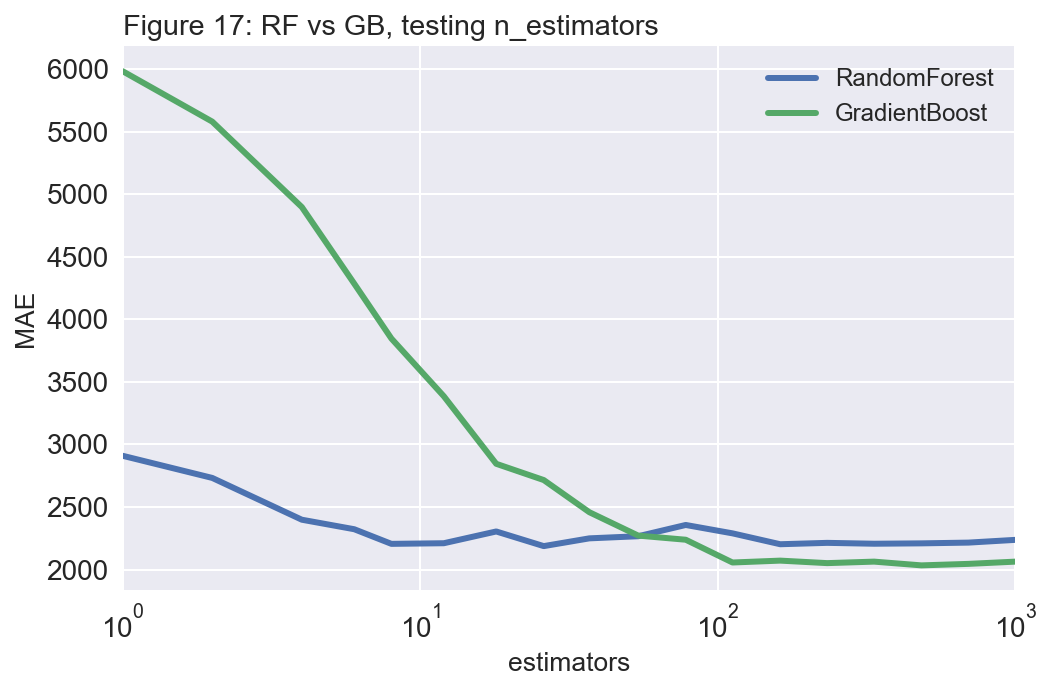

In [75]:
fig, ax = plt.subplots()
for group in groups.groups.keys():
    groups.get_group(group).plot(x='estimators', y='mae', ax=ax,
                                 label=group, lw=3, fontsize=14, logx=True)

plt.title('Figure 15: RF vs GB, testing n_estimators', loc = 'left')
plt.ylabel('MAE')
plt.show()

In [76]:
max_features = np.arange(5,45,5)
score_list = []
for n in max_features:
    models = [('GradientBoost',GradientBoostingRegressor(random_state=1, n_estimators=200, max_features = n, alpha = 0.01)),
          ('RandomForest',RandomForestRegressor(random_state=1, n_estimators=200, max_features = n))
             ]
    for model in models:
        RMSE = RMSE_CV(model[1])
        MAE = MAE_CV(model[1])
        score_list.append([model[0], n, RMSE, MAE])

In [77]:
df_scores = pd.DataFrame(score_list,columns=['model','max_features','rmse', 'mae'])
df_scores.head()

,model,max_features,rmse,mae
0,GradientBoost,5,3981.83,2121.0
1,RandomForest,5,4220.62,2407.0
2,GradientBoost,10,3856.96,1985.0
3,RandomForest,10,4139.21,2365.0
4,GradientBoost,15,3846.72,2073.0


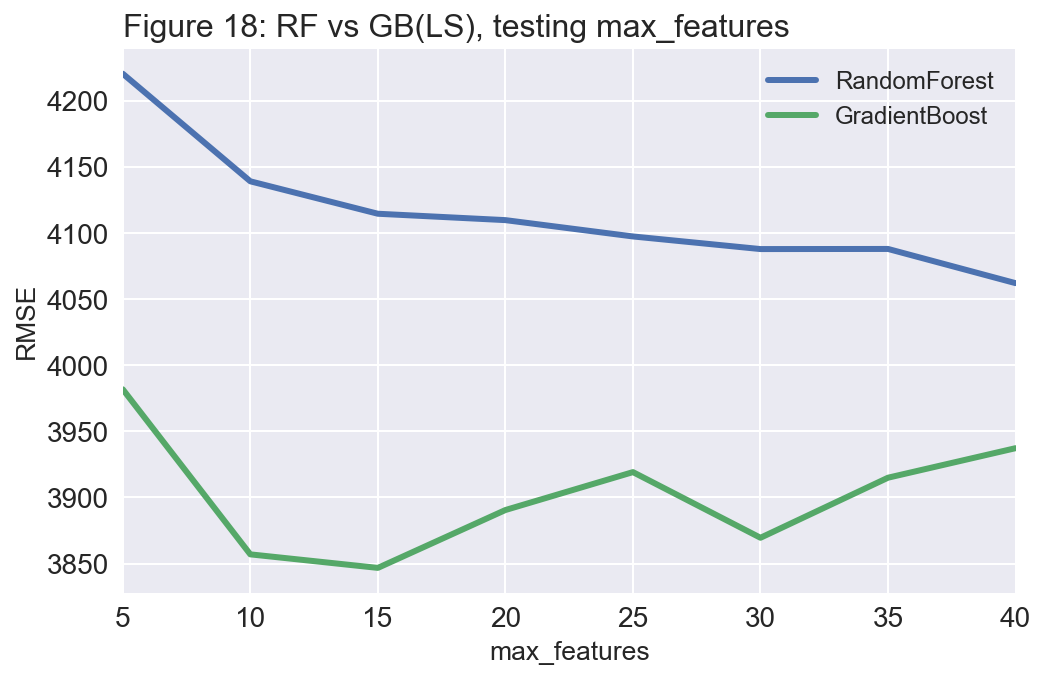

In [78]:
groups = df_scores.groupby('model')

fig, ax = plt.subplots()
for group in groups.groups.keys():
    groups.get_group(group).plot(x='max_features', y='rmse', ax=ax,
                                 label=group, lw=3, fontsize=14)

plt.title('Figure 16: RF vs GB(LS), testing max_features', loc = 'left', fontsize = fs)
plt.ylabel('RMSE')
plt.show()

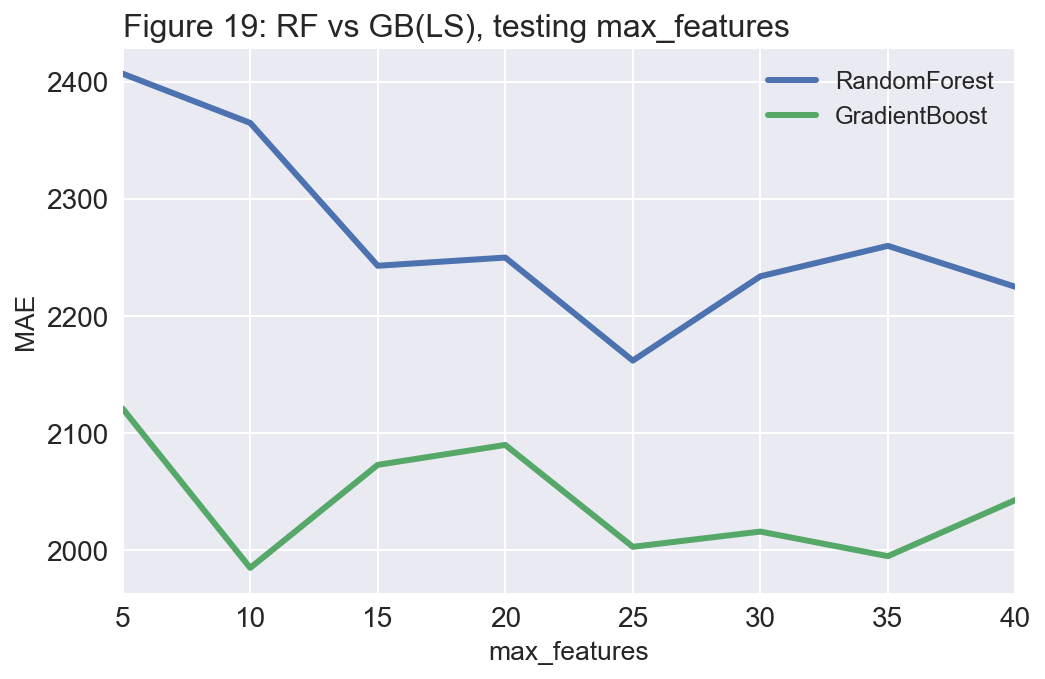

In [79]:
groups = df_scores.groupby('model')

fig, ax = plt.subplots()
for group in groups.groups.keys():
    groups.get_group(group).plot(x='max_features', y='mae', ax=ax,
                                 label=group, lw=3, fontsize=14)

plt.title('Figure 17: RF vs GB(LS), testing max_features', loc = 'left', fontsize = fs)
plt.ylabel('MAE')
plt.show()

###  Summary - Predicting Daily Hires
* Iterations included testing log transforming the target variable, multi-linear regression along with Lasso, Ridge and ElasticNet regularisation, followed by SupportVector Machines. 
* All three types regularisation performed similarly based on RMSEs similar to plain linear regression cross validation. Random Forest provided a step change improvement in performance, with an RMSE of 4113.
* During cross-validation, best performing model overall was the Gradient Boost Regressor with an RMSE of 3778. This produced a final RMSE on the test set of 3728 and MAE of 1997.
* The highest ranked features were `total_docks`, `wind_dir_deg` and `humidity`, the top 10 features only 1 non-weather variable but it is ranked highest.
* Gradient boosting is able to optimise for variance and bias by aggregating many shallow decision trees which has been sequentially built on the residuals from previous iterations.

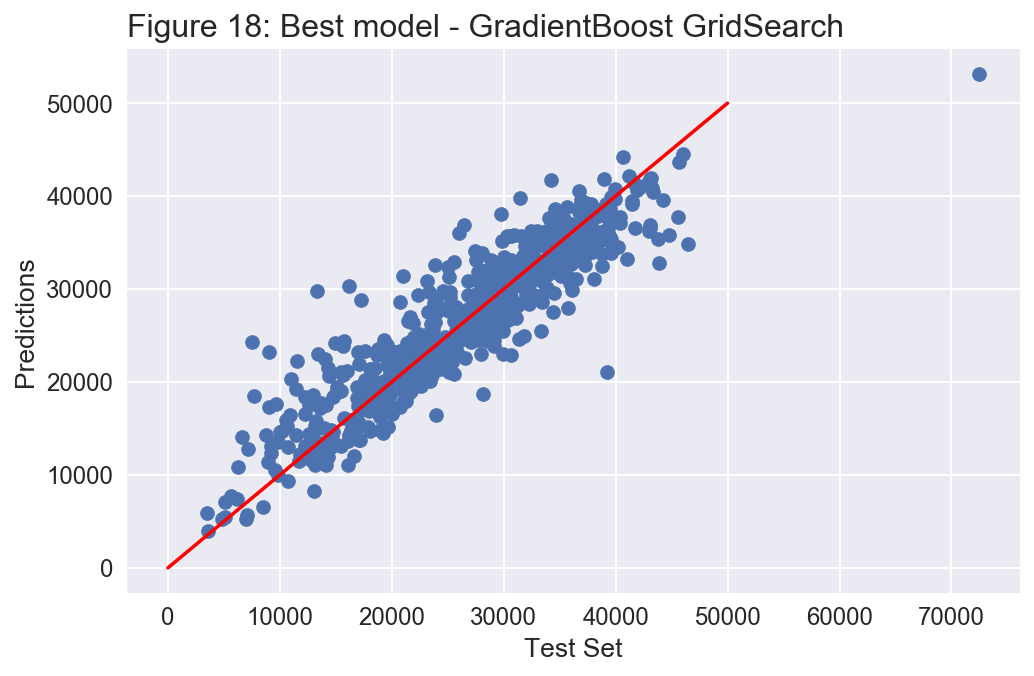

In [80]:
plt.scatter(y_test, list(preds))
point_1 = [0, 50000]
plt.plot(point_1,point_1, color = 'r')
plt.title('Figure 18: Best model - GradientBoost GridSearch ', loc = 'left', fontsize = fs)
plt.xlabel("Test Set")
plt.ylabel("Predictions")
plt.show()

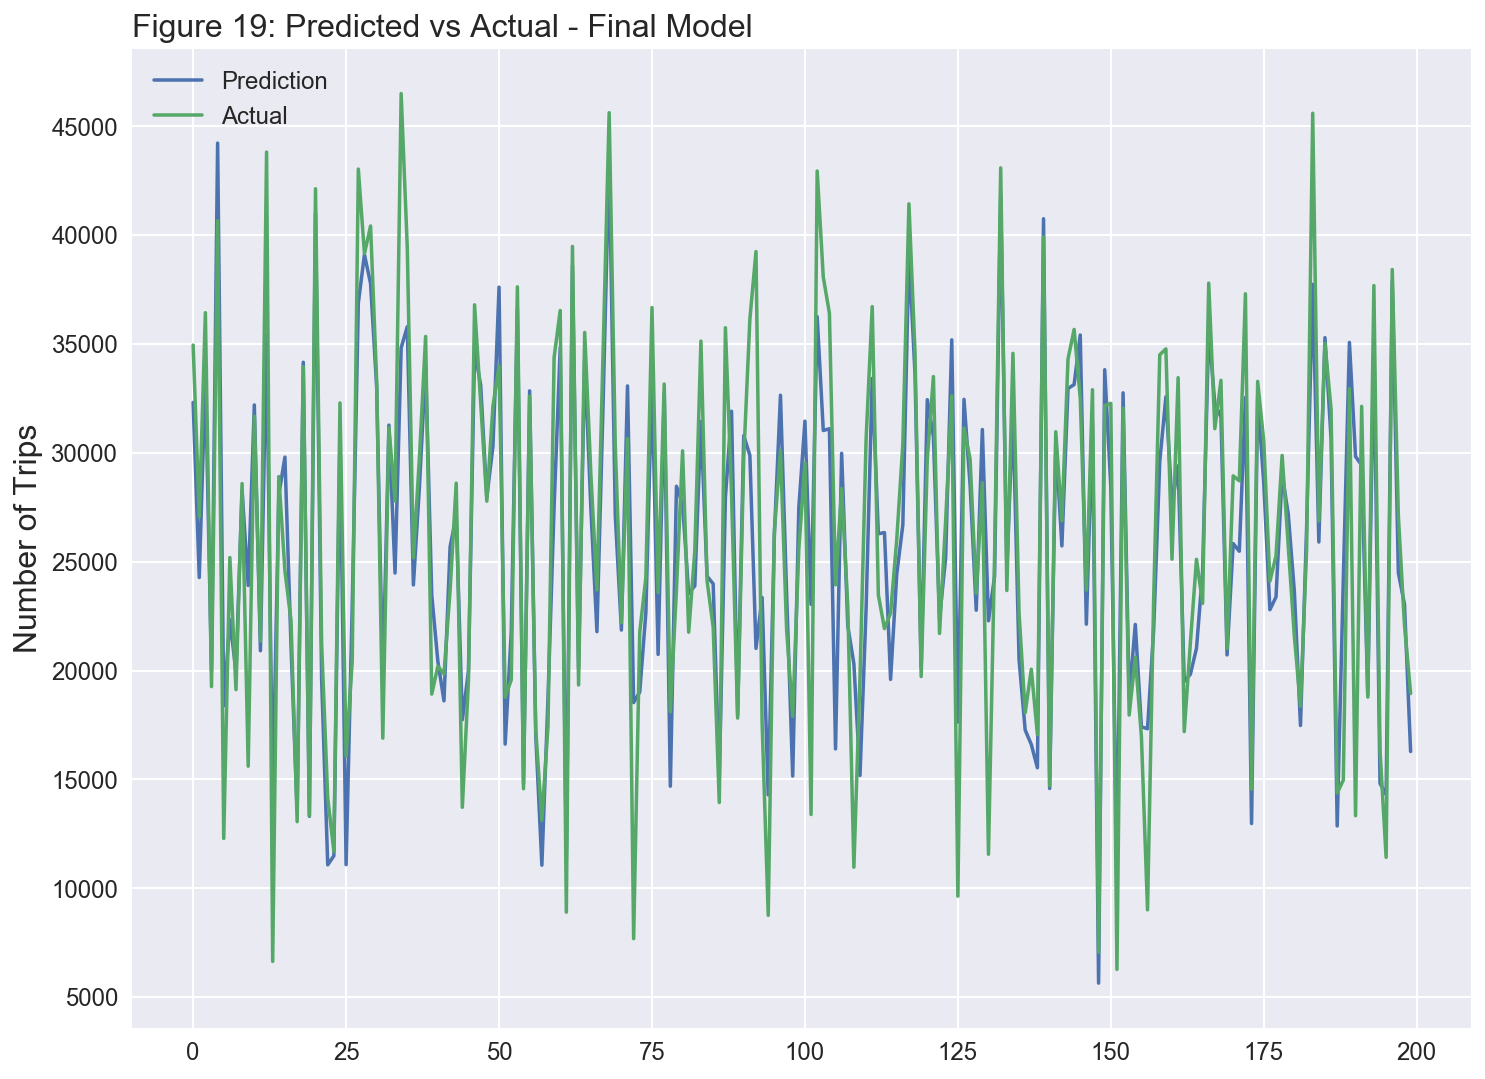

In [81]:
fs = 16
plt.figure(figsize=(12,9))
plt.plot(preds[:200])
plt.plot(y_test[:200])
plt.legend(['Prediction', 'Actual'])
plt.ylabel("Number of Trips", fontsize = fs)
plt.xlabel("", fontsize = fs)
plt.title("Figure 19: Predicted vs Actual - Final Model", fontsize = fs, loc = 'left')
plt.show()

In [65]:
summary = pd.DataFrame({'Method': method, 'RMSE':RMSE_metric})

In [67]:
summary

,Method,RMSE
0,LinearRegressionCV,4435.370000
1,LR_GSCV_Ridge,4443.286234
2,LR_GSCV_Lasso,4442.689987
3,LR_GSCV_Elastic,4444.420893
4,SVM_GS,4485.821275
5,RFR_GS,4113.283216
6,GBR_LAD,4046.050000
7,GBR_LS,3974.950000
8,GBR_GS,3778.722349


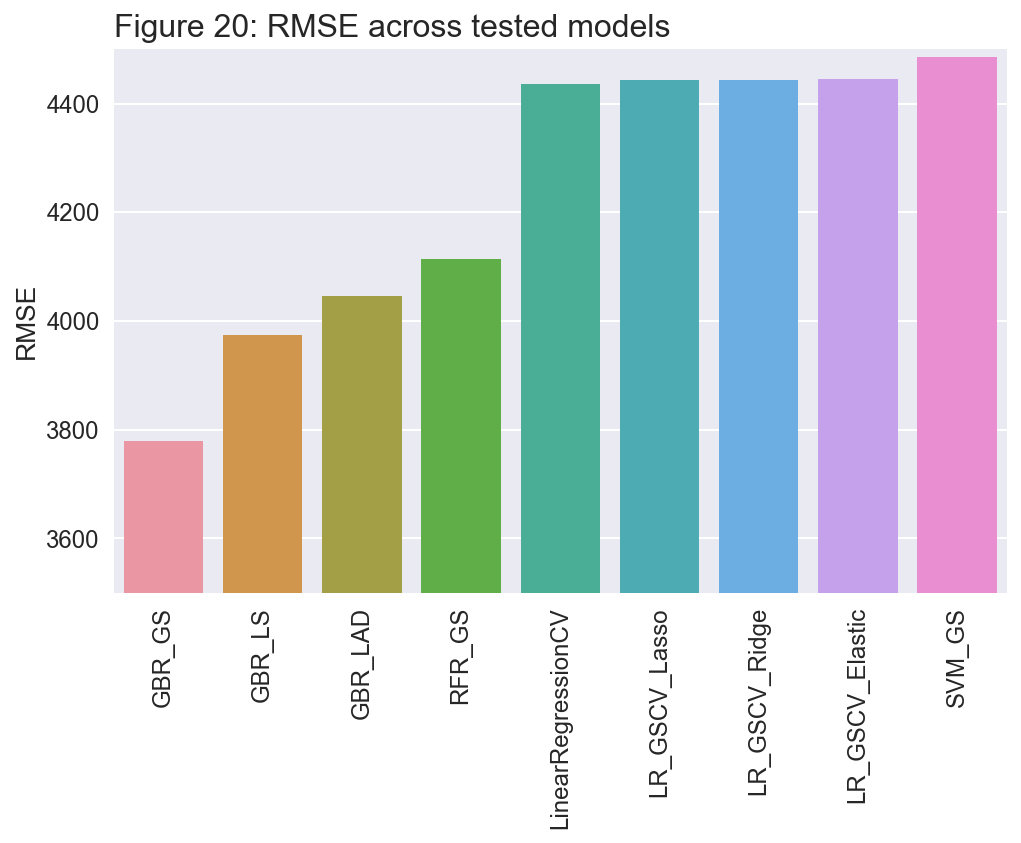

In [82]:
sns.barplot(data=summary.sort_values('RMSE', ascending = True), x = 'Method', y = 'RMSE')
plt.xticks(rotation = 90)
plt.title("Figure 20: RMSE across tested models", fontsize = fs, loc = 'left')
plt.xlabel('')
plt.ylim([3500,4500])
plt.show()


### Network Analysis

Network theory is the study of graphs as a representation of relations between discrete objects. A graph consists of a set of objects V called vertices and a set of edges E connecting pairs of vertices. The Santander Cycles system is an example of a network, with the docking stations presenting as *nodes* and the point A - point B journeys that users take as *edges*.

Using station id would be better for network analysis, since the docking station names can be very long. However, on closer inspection the start_station_id and end_station_id often have repetition for the same station e.g. Ada Street, Hackney Central is referenced as both 718 and 300040. 300040 is only used 269 times, all between 31st Aug and 6th September so it seems likely the ids were recorded incorrectly for some reason during this period. Therefore, the station names will be used but coverted to a numeric for the analysis using enumerate.

In [83]:
X2016 = pd.read_csv('X2016_geo.csv', index_col = 0)

/Applications/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [84]:
X2016.head()

,bike_id,duration,end_date,end_station_id,end_station_name,rental_id,start_date,start_station_id,start_station_name,start_lat,start_lon,end_lat,end_lon
0,8452.0,1200.0,2016-01-01 00:24:00,118.0,"Rochester Row, Westminster",50608187,2016-01-01 00:04:00,419,"Chelsea Bridge, Pimlico",51.485821,-0.149004,51.495827,-0.135478
1,8452.0,1200.0,2016-01-01 00:24:00,118.0,"Rochester Row, Westminster",50608187,2016-01-01 00:04:00,419,"Chelsea Bridge, Pimlico",51.485821,-0.149004,51.495827,-0.135478
2,529.0,1200.0,2016-01-01 00:24:00,118.0,"Rochester Row, Westminster",50608186,2016-01-01 00:04:00,419,"Chelsea Bridge, Pimlico",51.485821,-0.149004,51.495827,-0.135478
3,7151.0,1080.0,2016-01-01 00:22:00,251.0,"Brushfield Street, Liverpool Street",50608190,2016-01-01 00:04:00,66,"Holborn Circus, Holborn",51.517950,-0.108657,51.518908,-0.079249
4,7151.0,1080.0,2016-01-01 00:22:00,251.0,"Brushfield Street, Liverpool Street",50608190,2016-01-01 00:04:00,66,"Holborn Circus, Holborn",51.517950,-0.108657,51.518908,-0.079249


In [85]:
X2016.isnull().sum()

bike_id               0
duration              0
end_date              0
end_station_id        0
end_station_name      0
rental_id             0
start_date            0
start_station_id      0
start_station_name    0
start_lat             0
start_lon             0
end_lat               0
end_lon               0
dtype: int64

In [86]:
routes = X2016.groupby(['start_station_name', 'end_station_name']).size().unstack(fill_value = 0)

In [87]:
print X2016[X2016.start_station_name == 'Ada Street, Hackney Central'].start_station_id.unique()
X2016[X2016.start_station_id == 300040]

[   718 300040]


,bike_id,duration,end_date,end_station_id,end_station_name,rental_id,start_date,start_station_id,start_station_name,start_lat,start_lon,end_lat,end_lon
7118210,5849.0,1320.0,2016-08-31 04:24:00,3428.0,"Pancras Road, King's Cross",57834933,2016-08-31 04:02:00,300040,"Ada Street, Hackney Central",51.535716,-0.060291,51.534123,-0.129386
7120800,8722.0,900.0,2016-08-31 07:55:00,2699.0,"Snow Hill, Farringdon",57837579,2016-08-31 07:40:00,300040,"Ada Street, Hackney Central",51.535716,-0.060291,51.517334,-0.103604
7120972,5122.0,840.0,2016-08-31 07:57:00,3467.0,"Dock Street, Wapping",57837806,2016-08-31 07:43:00,300040,"Ada Street, Hackney Central",51.535716,-0.060291,51.509786,-0.068161
7120991,12419.0,360.0,2016-08-31 07:50:00,200244.0,"Hollybush Gardens, Bethnal Green",57837844,2016-08-31 07:44:00,300040,"Ada Street, Hackney Central",51.535716,-0.060291,51.527607,-0.057133
7121209,7866.0,720.0,2016-08-31 08:00:00,3438.0,"Devonshire Square, Liverpool Street",57838057,2016-08-31 07:48:00,300040,"Ada Street, Hackney Central",51.535716,-0.060291,51.516468,-0.079684
7121477,4125.0,1680.0,2016-08-31 08:20:00,1052.0,"Soho Square , Soho",57838325,2016-08-31 07:52:00,300040,"Ada Street, Hackney Central",51.535716,-0.060291,51.515631,-0.132328
7123329,5068.0,1140.0,2016-08-31 08:37:00,200123.0,"Burdett Road, Mile End",57840232,2016-08-31 08:18:00,300040,"Ada Street, Hackney Central",51.535716,-0.060291,51.516196,-0.029138
7123413,6417.0,840.0,2016-08-31 08:33:00,984.0,"Finsbury Circus, Liverpool Street",57840312,2016-08-31 08:19:00,300040,"Ada Street, Hackney Central",51.535716,-0.060291,51.517075,-0.086685
7124053,12619.0,600.0,2016-08-31 08:36:00,3483.0,"Fashion Street, Whitechapel",57840933,2016-08-31 08:26:00,300040,"Ada Street, Hackney Central",51.535716,-0.060291,51.518380,-0.073438
7124723,10838.0,1620.0,2016-08-31 09:01:00,200074.0,"Bury Place, Holborn",57841686,2016-08-31 08:34:00,300040,"Ada Street, Hackney Central",51.535716,-0.060291,51.517460,-0.123350


In [88]:
station_num = []
station_name = []
for i, j in enumerate(routes.index):
    station_num.append(i+1)
    station_name.append(j)    

In [89]:
nodes_df = pd.DataFrame({'station_num': station_num, 'station':station_name})
journeys = pd.read_csv('station_journeys.csv', index_col = 0)
nodes_full = pd.merge(journeys, nodes_df, on='station')

In [120]:
journeys.head()

,station,deficit,end,lat,lon,start,num_docks,size_dock,popularity
0,"Abbey Orchard Street, Westminster",-3573.0,19622.0,51.498125,-0.132102,16049.0,29,Medium,Average
1,"Abbotsbury Road, Holland Park",300.0,3754.0,51.501391,-0.205991,4054.0,24,Medium,Quiet
2,"Aberdeen Place, St. John's Wood",1621.0,6075.0,51.524826,-0.176268,7696.0,18,Small,Below Average
3,"Aberfeldy Street, Poplar",4.0,1582.0,51.513548,-0.005659,1586.0,16,Small,Quiet
4,"Abingdon Green, Westminster",-3916.0,24313.0,51.497622,-0.125978,20397.0,20,Small,Above Average


In [90]:
# Creating a dictionary of edges to use to populate the directed graph.
# Removing the journeys which started and ended at the same station.
# Do not want a dock to be referred to as 0.

network_num = {}
for i, j in enumerate(routes.index):
    for k, l in enumerate(routes.columns):
        if i != k:
            network_num[(i+1,k+1)] = routes.loc[j, l]


In [91]:
# Removing the routes which no journeys occurred on i.e. there should be no connecting edge.
network_num = {k:v for k, v in network_num.items() if v != 0}

In [92]:
DG = nx.DiGraph()
DG.add_nodes_from(nodes_df['station_num'])
for i, j in network_num.items():
    DG.add_edge(i[0], i[1], weight=j)

In [93]:
print nx.info(DG)
print "Adjacency matrix: "
print nx.adjacency_matrix(DG).todense()
# In an undirected graph the adjacency matrix shows boolean values i.e. connected or not.
# However, for a directed graph, the edge weights between two nodes are depicted.  
# When todense() is called, it fills the slots where no journeys took place with 0.

Name: 
Type: DiGraph
Number of nodes: 768
Number of edges: 356854
Average in degree: 464.6536
Average out degree: 464.6536
Adjacency matrix: 
[[ 0  0  4 ...,  9 15  1]
 [ 0  0  2 ...,  0 95  0]
 [ 0  0  0 ...,  4  8  1]
 ..., 
 [17  0  1 ...,  0  2 10]
 [16 57  8 ...,  0  0  0]
 [ 3  0  0 ...,  7  0  0]]


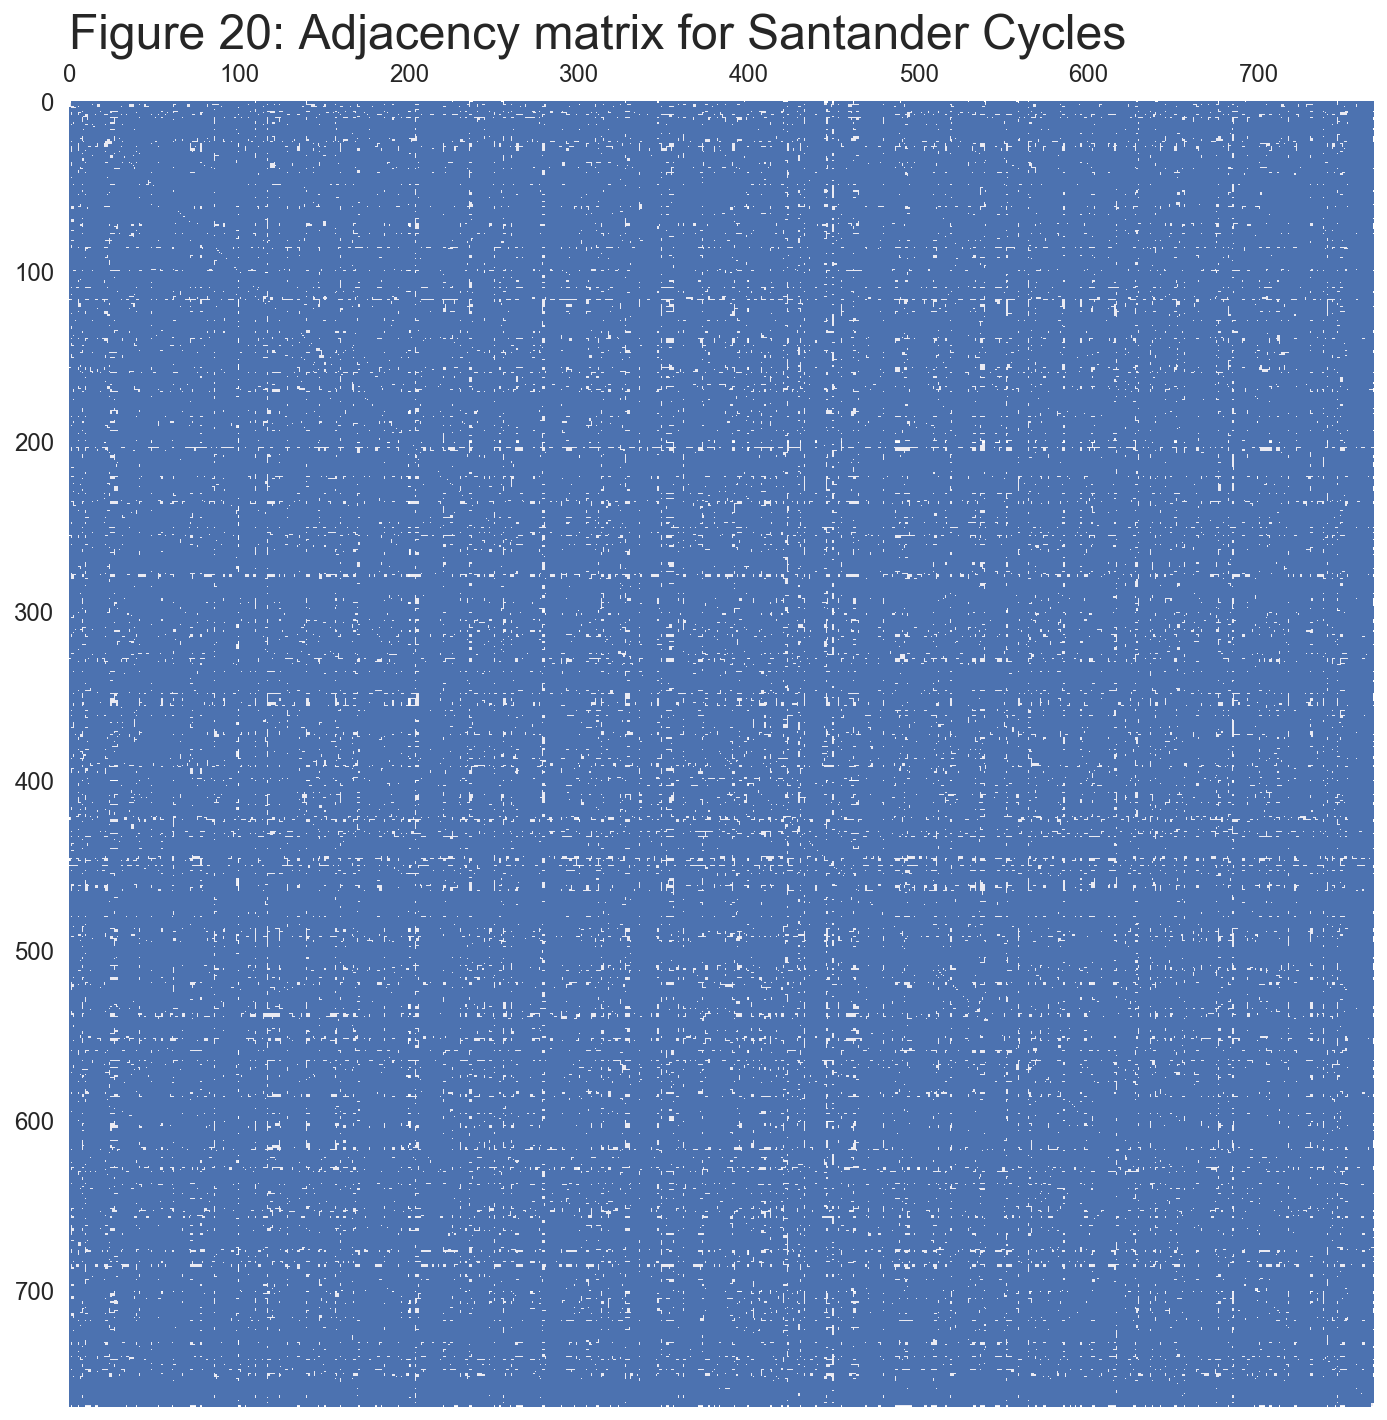

In [146]:
plt.figure(figsize=(12,12))
plt.spy(nx.adjacency_matrix(DG),markersize=2)
plt.xlabel('')
plt.ylabel('')
plt.title('Figure 20: Adjacency matrix for Santander Cycles', loc = 'left', fontsize = 24, y = 1.03)
plt.show()
# Suggests the vast majority of docking stations had at least 1 journey from one station
# to another, the order the nodes are displayed in could help to draw out information.
# Currently alphabetical based on docking station name.

Degree distribution displays the number of nodes with a given degree i.e. how many links the node has. In the context of the bike share scheme, this is looking at each station and analysing: 
1. Stations people have journeyed to from this dock (Out)
2. Stations people have arrived from at this dock (In) <br>

Both in- and out-degree are displayed on the histogram. The distribution for both are very similar. The average values for in- and out-degree are exactly the same as would be expected. The distribution peaks in the 400-500 degree bin for both in- and out-, displaying weakly negative skewness.

In [140]:
# Adding degree into dataframe:
degree = dict(nx.degree(DG))
degree_df = pd.DataFrame(degree.items())
degree_df.columns=['node','degree']
journeys['degree'] = degree_df['degree']

In [143]:
journeys.tail(10)

,station,deficit,end,lat,lon,start,num_docks,size_dock,popularity,degree
635,"St. James's Square, St. James's",-9498.0,36435.0,51.507424,-0.134621,26937.0,40,Medium,Above Average,1395
610,"Somerset House, Strand",-1992.0,26430.0,51.509943,-0.117619,24438.0,41,Large,Above Average,1400
404,"Little Argyll Street, West End",-4263.0,31836.0,51.514499,-0.141423,27573.0,21,Medium,Above Average,1402
288,"Green Park Station, Mayfair",-3034.0,35916.0,51.506613,-0.142844,32882.0,28,Medium,Above Average,1411
719,"Wardour Street, Soho",-2645.0,28137.0,51.512515,-0.133201,25492.0,16,Small,Above Average,1412
339,"Hop Exchange, The Borough",-18168.0,67054.0,51.504627,-0.091773,48886.0,56,Large,Very Busy,1413
442,"Moor Street, Soho",-2094.0,28821.0,51.513527,-0.130110,26727.0,16,Small,Above Average,1415
756,"William IV Street, Strand",-9793.0,40909.0,51.509462,-0.124749,31116.0,25,Medium,Above Average,1422
172,"Craven Street, Strand",-3343.0,43866.0,51.508103,-0.126021,40523.0,23,Medium,Very Busy,1445
754,"Whitehall Place, Strand",-3184.0,37737.0,51.506543,-0.123179,34553.0,24,Medium,Above Average,1450


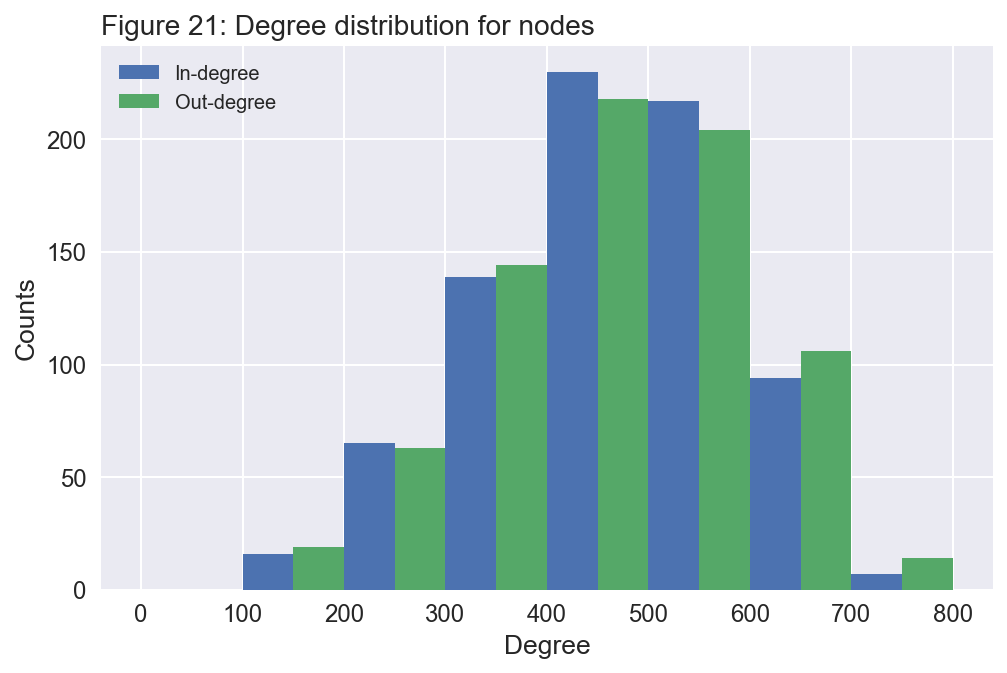

In [95]:
plt.hist([dict(DG.in_degree()).values(),dict(DG.out_degree()).values()], rwidth=1.5, stacked=False, bins=np.linspace(0,800,9))
plt.xlabel('Degree')
plt.ylabel('Counts')
plt.legend(['In-degree','Out-degree'],prop={'size': 10},
           loc='upper left')
plt.title('Figure 21: Degree distribution for nodes', loc = 'left', fontsize = 14)
plt.show()

#### Shortest path

If two nodes can be reached along a sequence of links, there is a path connecting them. The shortest one of them can be determined by starting at one of the nodes, and then checking if the other node is among the neighbours, second neighbours and so on until it is found. 

In [96]:
print nx.average_shortest_path_length(DG)

1.39419342134


#### Centrality Measures 

*Rankings of nodes or edges based on their importance to the network* 

Betweenness centrality for a node is equal to the number of shortest paths from all nodes to all others that pass through that node. For edge betweenness it is a count of how many of these paths run through that link, this is slow to run for the dataset due to the number of edges.<br>
<br>
Whitehall Place on the Strand is the highest ranked dock for betweeeness centrality, 5 of the other top 20 nodes for betweenness centrality are also on the Strand.<br>
<br>


In [97]:
node_centrality = nx.betweenness_centrality(DG)
edge_centrality = nx.edge_betweenness_centrality(DG)

In [98]:
nodes_df['betweenness'] = node_centrality.values()
sorted_btwn = nodes_df.sort_values('betweenness', ascending = False).head(10)

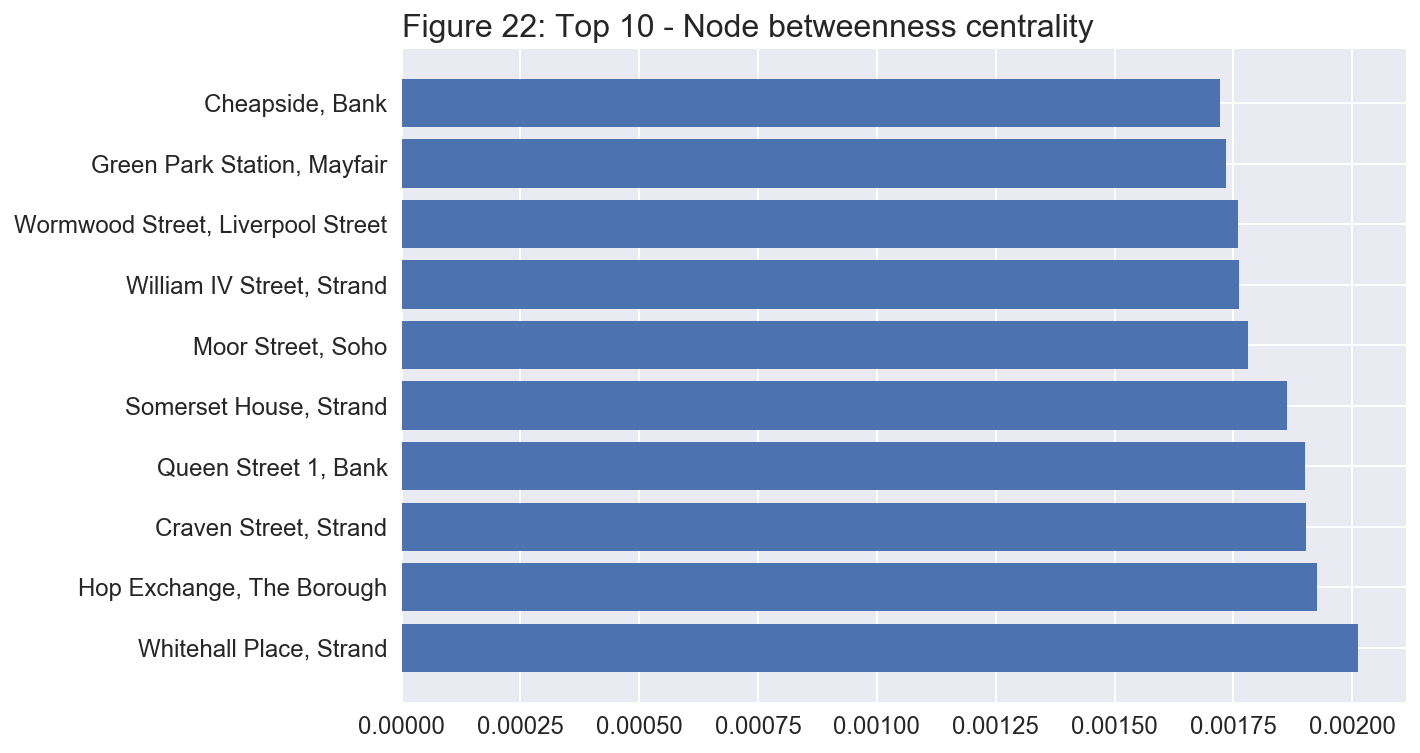

In [99]:
plt.figure(figsize = (9,6))
plt.barh(range(10),
         sorted_btwn.betweenness.values)
plt.yticks(range(10), sorted_btwn.station.values)
plt.title('Figure 22: Top 10 - Node betweenness centrality', loc = 'left', fontsize = 16)
plt.show()

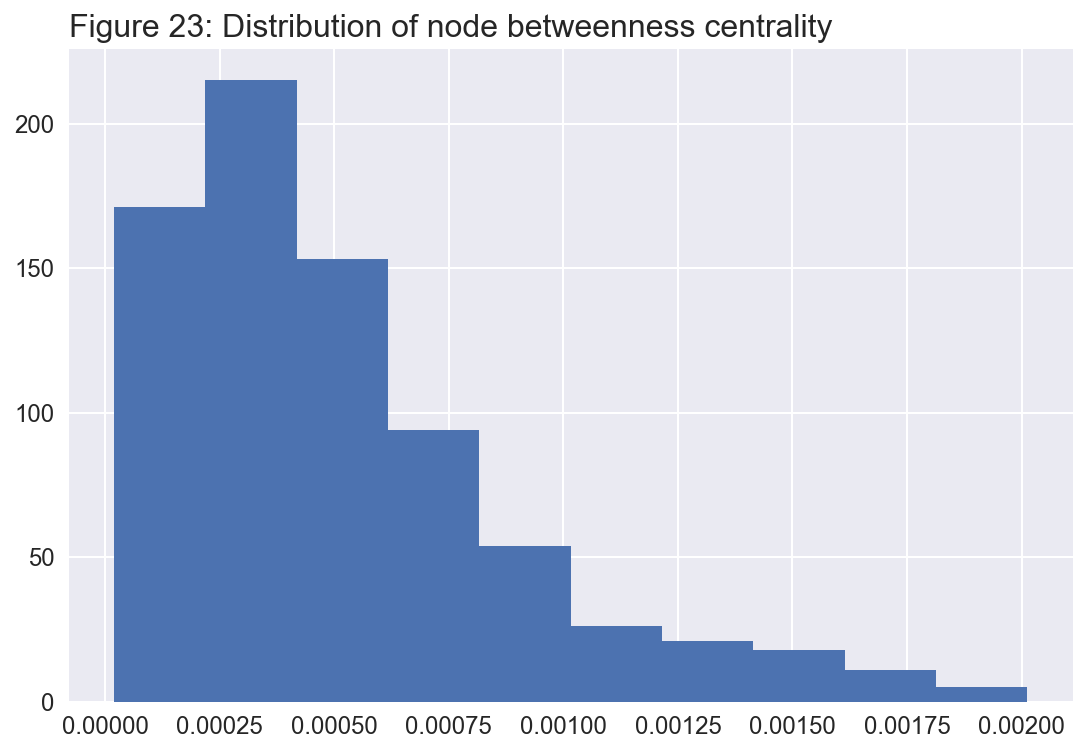

In [100]:
plt.figure(figsize = (9,6))
plt.hist(node_centrality.values())
plt.title('Figure 23: Distribution of node betweenness centrality', loc = 'left', fontsize = 16)
plt.show()

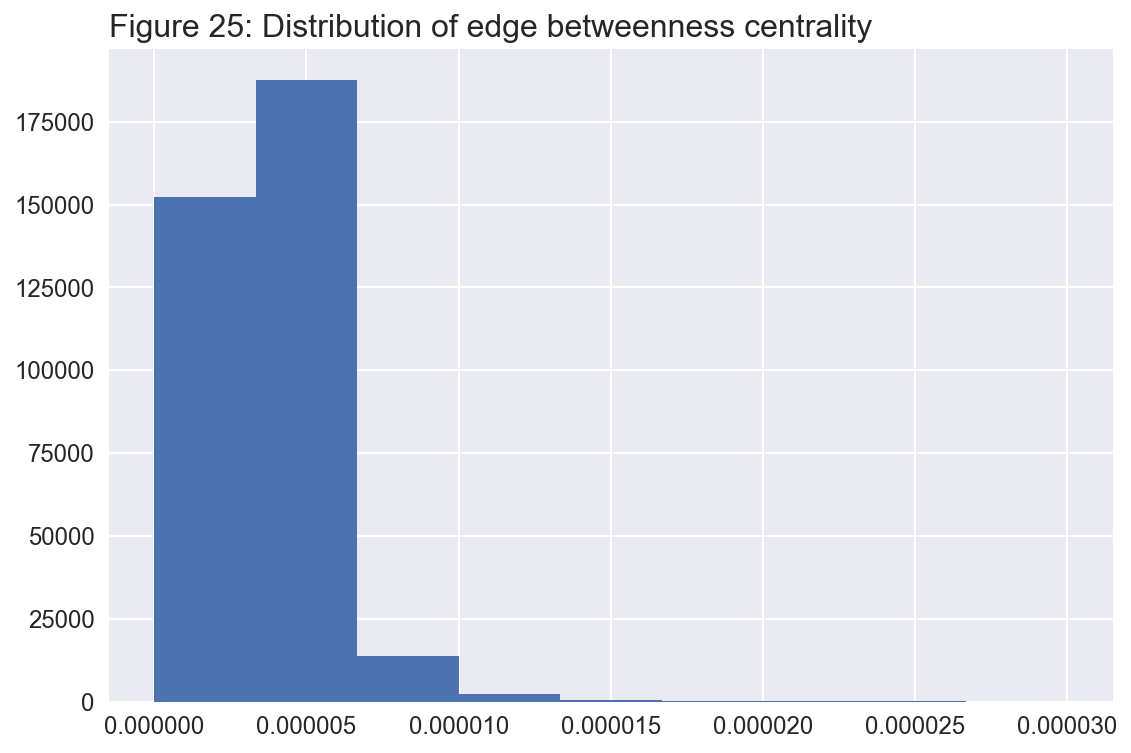

In [101]:
plt.figure(figsize = (9,6))
plt.hist(edge_centrality.values(), bins = np.linspace(0,0.00003,10))
plt.title('Figure 25: Distribution of edge betweenness centrality', loc = 'left', fontsize = 16)
plt.show()

#### Strongly Connected Components
A directed graph is strongly connected if there is a path between all pairs of nodes. All the nodes fall within a single strongly connected component.

In [102]:
scc = list(max(nx.strongly_connected_components(DG), key=len))
IN_component = [list(DG.predecessors(n)) for n in scc]
IN_component = sorted(list(set(np.unique(np.concatenate(IN_component))) - set(scc)))

OUT_component = [list(DG.successors(n)) for n in scc]
OUT_component = sorted(list(set(np.unique(np.concatenate(OUT_component))) - set(scc)))

In [103]:
print len(scc)
print len(IN_component)
print len(OUT_component)

768
0
0


#### Spearman Rank coeffficient

The in-degree and out-degree are both highly correlated with betweenness centrality.

In [104]:
spearmanr(dict(DG.in_degree()).values(),node_centrality.values())

SpearmanrResult(correlation=0.97702967614698022, pvalue=0.0)

In [105]:
spearmanr(dict(DG.out_degree()).values(),node_centrality.values())

SpearmanrResult(correlation=0.97148862888044241, pvalue=0.0)

#### PageRank
PageRank computes a ranking of the nodes in the graph DG based on the structure of the incoming links. It was originally designed as an algorithm to rank web pages - using links between pages as a measure of importance. In the context of this study, each docking station is assigned a score based upon its number of in-coming links. These links are also weighted depending on the relative score of its originating node. The result is that nodes with many in-coming links are influential, and nodes to which they are connected share some of that influence.


In [106]:
pagerank = nx.pagerank(DG, alpha=0.85, weight='weight')
pagerank_df = pd.DataFrame(pagerank.values(), index = pagerank.keys())
pagerank_df['station_name'] = nodes_df['station']
pagerank_df.rename(columns={0:'page_rank'},inplace=True) 
pagerank_sorted = pagerank_df.sort_values('page_rank', ascending = False).head(10)

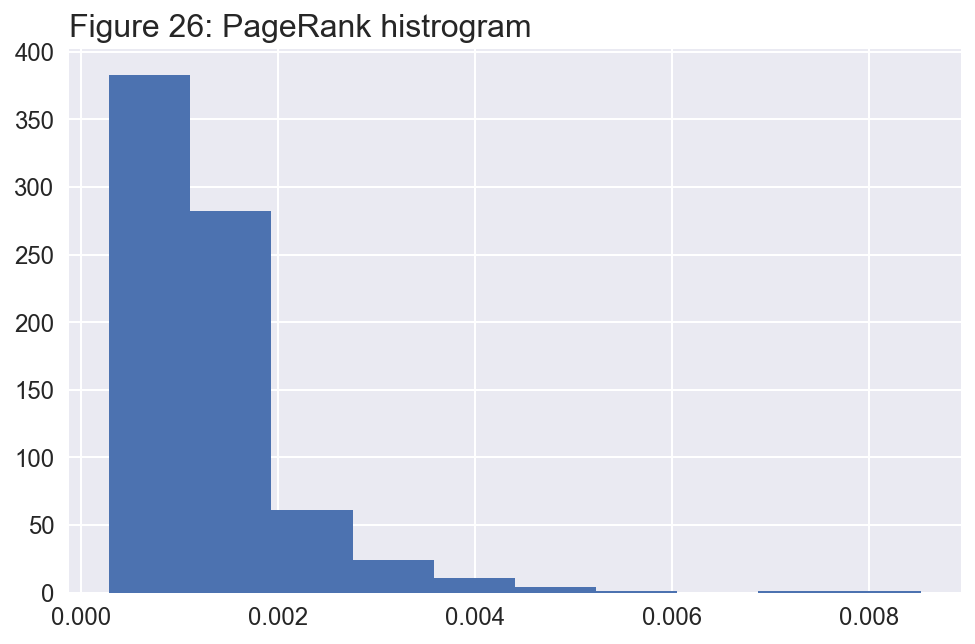

In [107]:
plt.hist(pagerank.values())
plt.title('Figure 26: PageRank histrogram', loc = 'left', fontsize = 16)
plt.show()

In [108]:
page_ranks = np.array(pagerank_sorted.page_rank)
rank_names = list(pagerank_sorted.station_name)

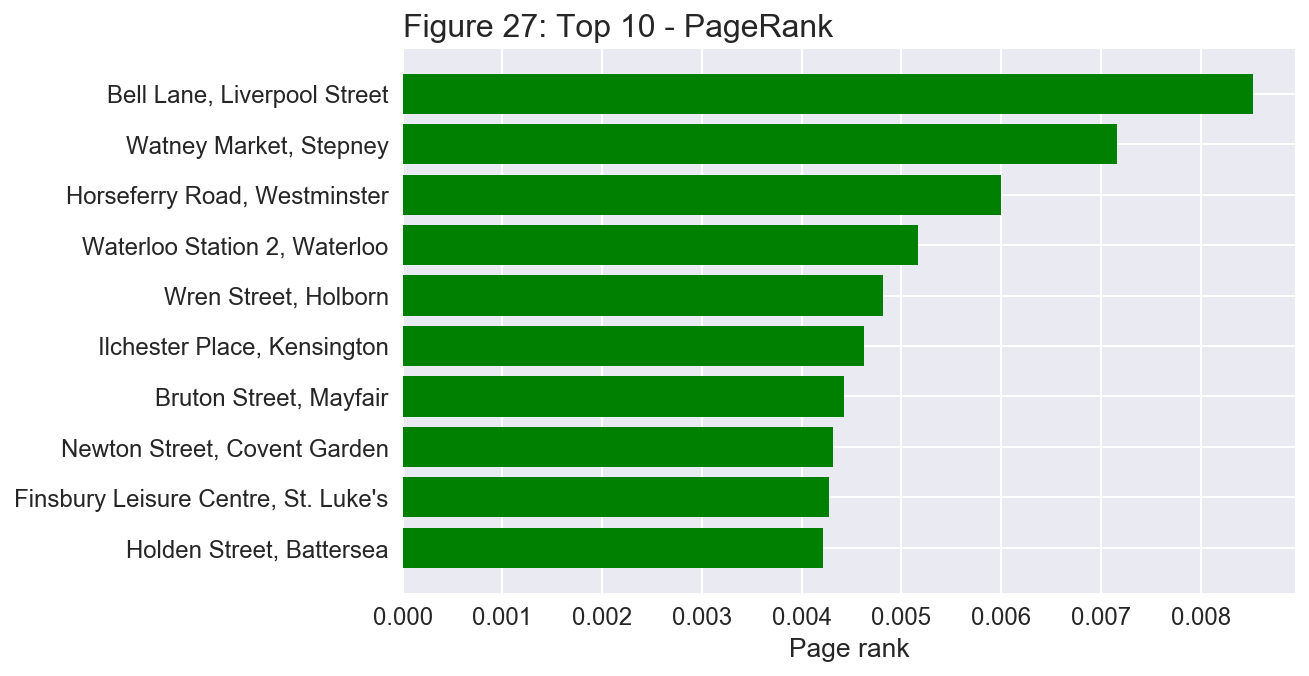

In [109]:
fig, ax = plt.subplots()
y_pos = np.arange(len(page_ranks))

ax.barh(y_pos, page_ranks, align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(rank_names)
ax.invert_yaxis() 
ax.set_xlabel('Page rank')
ax.set_title('Figure 27: Top 10 - PageRank', loc = 'left', fontsize = 16)
plt.show()

#### Community Detection - Hierarchical/Agglomerative Clustering

*Identifying groups of nodes which are more closely related to each other than to other nodes in the network* 

The distance matrix is defined from the adjacency matrix by defining some similarity measure between the nodes. For example, **cosine similarity** can be calculated for each pair of row vector $x$ and column vector $y$ of the adjacency matrix obtaining:

$$\sigma_{ij} = \frac{x\cdot y}{\|x\|\|y\|}$$

In this context, it is high if two nodes share a large number of common neighbours. There are a variety of methods for calculating the distance between each newly formed cluster and all the other clusters:
* Average method: Proximity between two clusters is the arithmetic mean of all the proximities between the objects of one, on one side, and the objects of the other, on the other side. 
* Wards method: Proximity between two clusters is the magnitude by which the summed square in their joint cluster will be greater than the combined summed square in these two clusters.

The resulting dendogram can be used to obtain different numbers of communities by cutting it at different heights. 

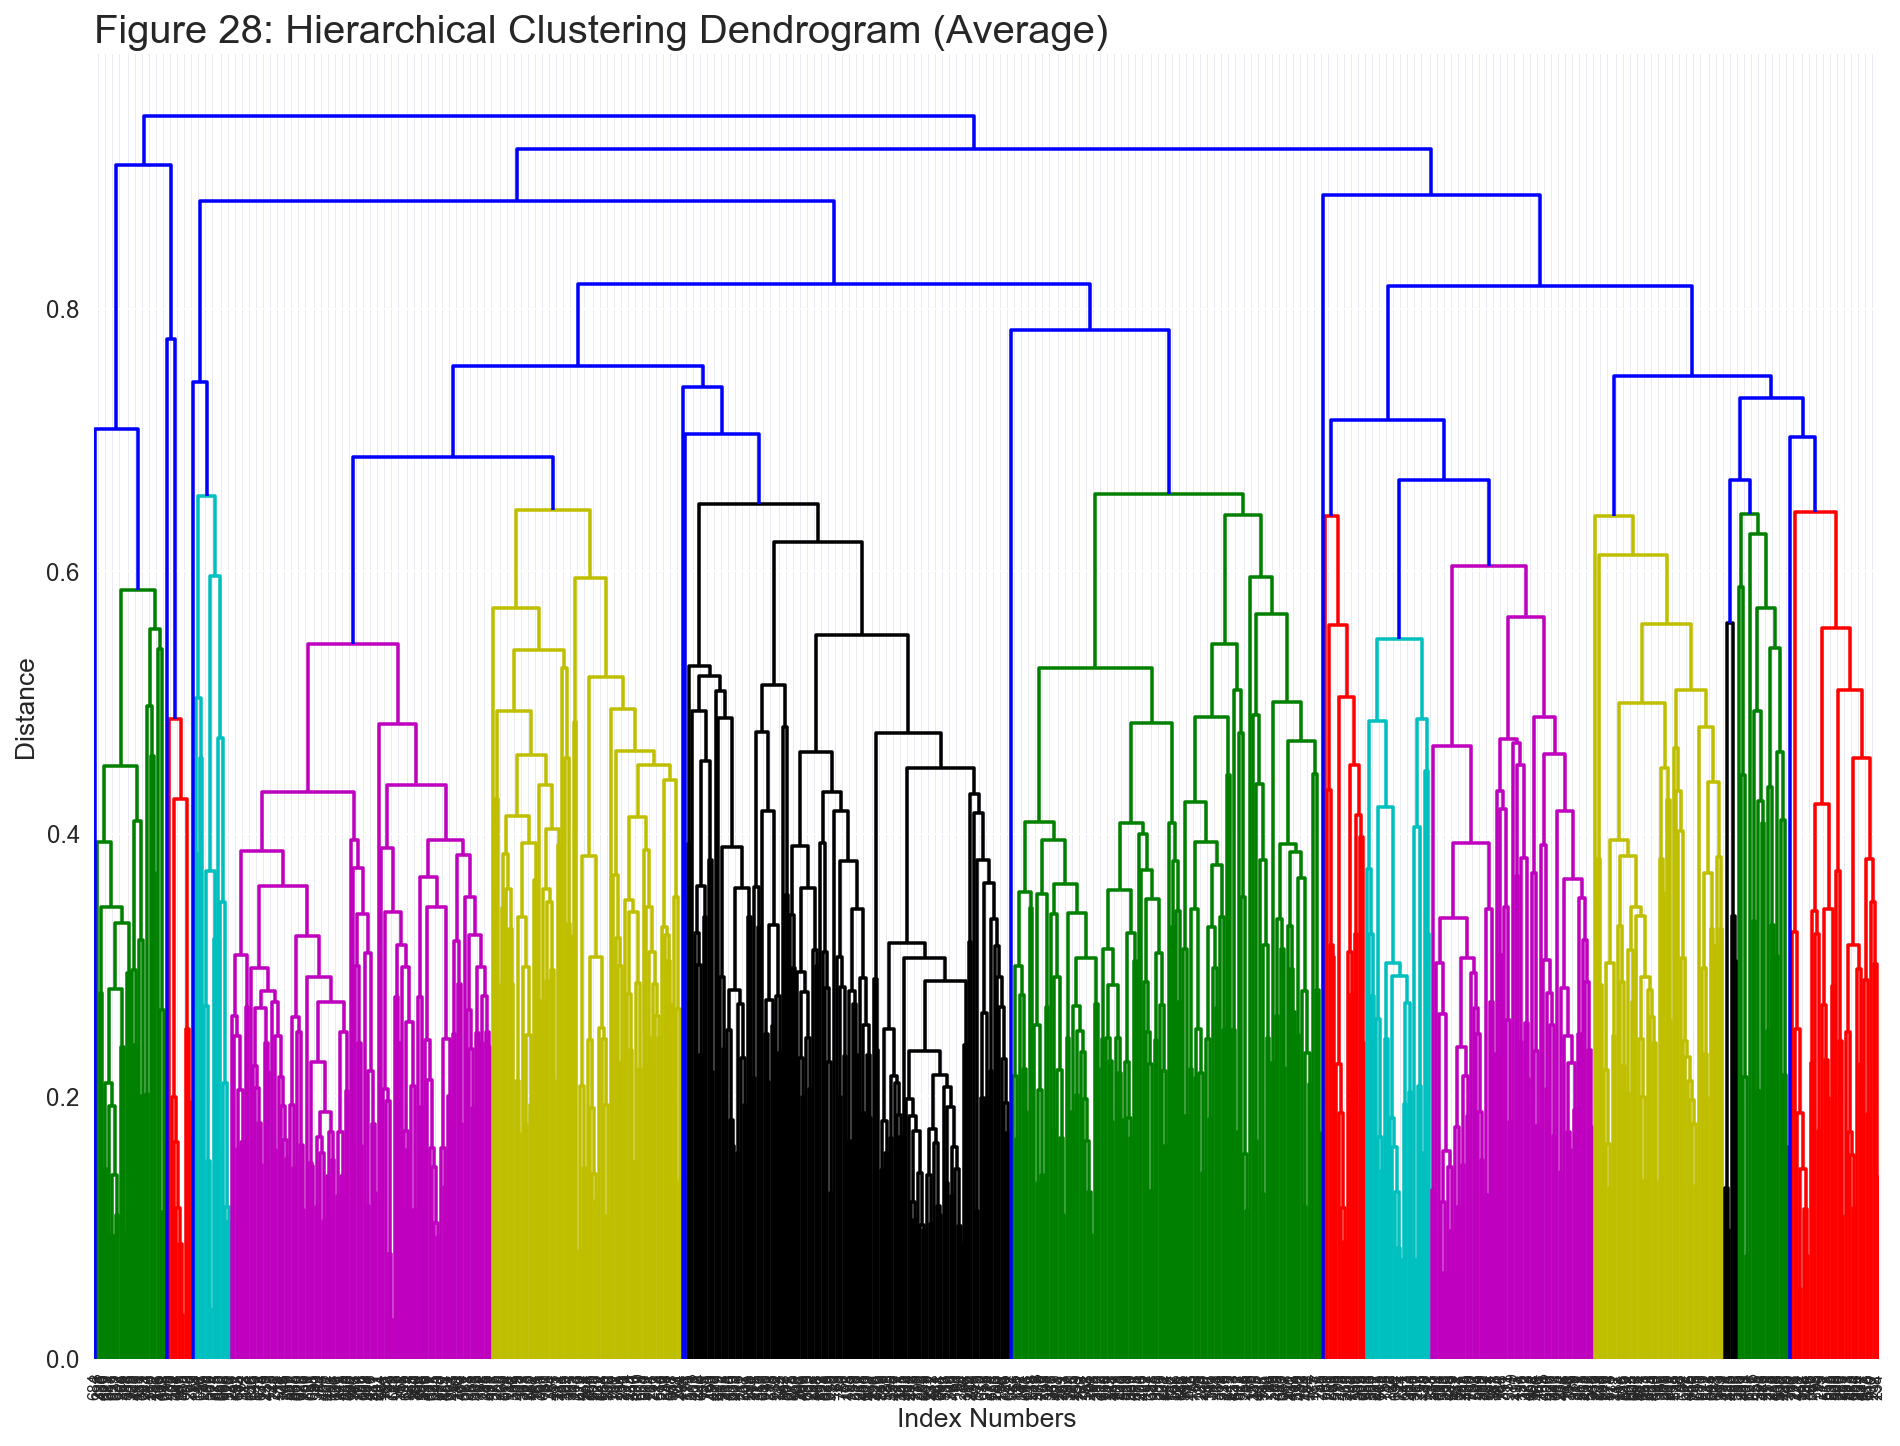

In [110]:
plt.figure(figsize = (16,12))
A = nx.adjacency_matrix(DG).toarray()
dist_out = pdist(A,metric='cosine')
Z = hierarchy.linkage(dist_out,method='average')
hierarchy.dendrogram(Z,leaf_rotation=90., leaf_font_size=8.)
plt.title('Figure 28: Hierarchical Clustering Dendrogram (Average)', loc = 'left', fontsize = 20)
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
plt.show()

In [ ]:
def plot_clusters(max_dist):
    '''Runs clustering algorithm using distance criterion and create scatter plot of
    docks coloured by the assigned cluster'''
    # Run clustering algorithm with max_dist from function input
    clusters = fcluster(Z, max_dist, criterion='distance')
    # Create dictionary from cluster assignment and station names
    c_dict = dict(zip(nodes_df.station,clusters))
    sorted_key = sorted(c_dict.items(), key=operator.itemgetter(0))
    cluster_df = pd.DataFrame(sorted_key)
    journeys['cluster'] = cluster_df.iloc[:, 1]
    # Plot the cluster assignment geographically
    g = sns.lmplot( x='lon', y='lat', data=journeys, fit_reg=False, hue='cluster', legend=True)
    g.fig.set_size_inches(12,7)
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    plt.title('Hierarchical clusters from adjacency matrix, max_dist: %.2f' %(max_dist, ))
    plt.show() 


In [ ]:
plot_clusters(0.9)

In [ ]:
Image(filename='cluster_4.png')

In [ ]:
plot_clusters(0.8)

In [ ]:
Image(filename='cluster_8.png')

Since cosine similarity is high if two nodes share a large number of common neighbours, the cluster patterns displayed on the graphs indicate docking stations which have a large number of journeys between them. 
* Slicing the dendogram at 0.9 yields 4 distinct communities, the largest (#3) covering the vast majority of central London with a separate distinct community to the west, and two to the east.
* Slicing the dendogram at 0.8 yields 8 distinct communities, the large central cluster is split into a western and eastern portion indicating more journeys are travelling north-south than east-west. However, the western cluster is split into a northern and a southern cluster, indicating more journeys are travelling east-west than north-south. Baron's Court is singled out in its own cluster. 
* Based on analysis using Tableau, this western divide does not appear to be caused by the River Thames. In fact, the clusters show no clear expression of the Thames acting as a barrier to connectivity at all. This might be due to the high level of bridges crossing the river in West London. One barrier which is apparent is the railway lines at the south eastern corner of Battersea Park. They run between the red and purple clusters on the Tableau map.

In [ ]:
# Evaluate the number of clusters vs the threshold used graphically. There is a change in gradient in
# the line at around 0.5 - there are still c.70 clusters at this stage.
cluster_num = []
for max_d in np.arange(0,1,0.1):
    clusters = fcluster(Z, max_d, criterion='distance')
    cluster_num.append((max_d,len(set(clusters))))
    
plt.plot(np.array(cluster_num)[:,0],np.array(cluster_num)[:,1])
plt.xlabel('Threshold')
plt.ylabel('Number of clusters')
plt.title('Figure 29: Clusters vs Threshold - Average method', loc = left, fontsize = 16)
plt.show()

In [ ]:
# Testing the Ward metric of similarity instead:
plt.figure(figsize = (16,12))
Z = hierarchy.linkage(dist_out,method='ward')
hierarchy.dendrogram(Z,leaf_rotation=90., leaf_font_size=8.)
plt.title('Figure 30: Hierarchical Clustering Dendrogram (Ward)', loc = 'left', fontsize = 20)
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
plt.show()

In [ ]:
 plot_clusters(4)

In [ ]:
Image(filename='clusters_ward.png')

In [ ]:
journeys.groupby('cluster').size()

#### Summary - Network Analysis
* Directed graph has 768 nodes (docking stations) and 356854 edges (routes), weighted with number of journeys on that route. Directed means A-B and B-A are counted separately. 
* Average in degree and out degree is 464, indicating how many links the node has to other nodes. Weakly negative skewed distribution, indicating there are more nodes with fewer connections than there are nodes with higher connections. 
* When two nodes are connected by an edge, we say that they are adjacent. Adjacency matrix contains the number of journeys between each node and each other node. Difficult to interpret visually though its clear from the 'cross-hatch' pattern that some stations are VERY well connected.
* Betweenness centrality is equal to the number of shortest paths from all nodes to all others, that pass through that node. Whitehall Place, Strand comes top - in fact 3 of the top 5 docks are situated on the Strand, a main thoroughfare in central London.
* Edge betweenness centrality has a very narrow distribution, the majority of the edges have a similar edge betweenness centrality.
* PageRank ranks the nodes based on number of incoming edges and nodes to which they are connected also share some of that influence. The top 10 is quite a mixed bag of stations that have not ranked highly by any other measures (with the exception of Waterloo Station 2). These nodes are journeyed to from nodes which also receive journeys from a wide range of docks.
* Agglomerative clustering indicates that the river is not acting as a strong barrier to journeys, though it may well do if the scheme was introduced in the south east due to the lack of river crossings. Railway lines act as a baffle in at least one location. It indications journeys tend to follow a north-south direction in central London, and an east-west direction towards the suburbs. Using `ward` as the distance metric yields substantially different results when compared to `average` for a similar number of clusters. It results in more evenly sized clusters, with three covering central London rather than 1 large cluster.

### Future Work

* Acquire and incorporate redistribution data from Serco or TFL.
* Build a classification based model to predict whether a docking spot will be free when arriving at a dock e.g. 'Spaces' or 'Full'. A step further than this, would be to then perform a distance calculation and repeat the process for the next nearest dock until one with 'Spaces' is found.
* Develop a Flask app to allow host the outputs from this model.

### Production Considerations

* Hire data is made available in chunks of two week data which would need to be constantly  incorporated and the model retrained. Certain predictors are intrinsically variable such as the weather but others tend not to change such as distribution of public holidays through the year. There are also external factors which are not currently taken into account, such as the rise of dockless bike schemes in London, which may take trade away from the Santander Cycles scheme.
* The model could be deployed within a Flask app to provide an on the day indication of how busy the network is likely to be based on the forecasted weather, obtained via the WorldWeather Online API, plus predefined considerations such as day of the week, whether it's a public holiday and the total number of docks currently active across the network via the TFL API. Spell out the baseline value for the model and also the current model accuracy using Median Absolute Error to give an indication how many journeys the prediction may be out by.
* Use inexpensive Cloud-based data storage such as Amazon's S3 to store the input data, and an AWS EC2 instance to deploy the app.
* To tie in with possible futre work, a useful addition to the app would be the ability to input a date and time of travel, plus a destination station then predict whether there would be availability by the time of arrival.